# Table of Contents <a class="anchor" id="backtotop"></a>

* 1\. [Data Cleaning and Processing](#cleaning)
    * 1\.1 [Imports](#imports)
    * 1\.2 [IB Results](#ibresults)
    * 1\.3 [Math Placement Data](#mathplacement)
    * 1\.4 [Mergeing IB and Math Results](#mergingresults)
    * 1\.5 [Labeling Appropriate Class](#labelingclass)
* 2\. [EDA](#edadata)
    * 2\.1 [Split Data](#splitdata)
    * 2\.2 [Label Distribution](#label)
    * 2\.3 [Outliers by Skill](#outliers)
    * 2\.4 [Subject vs Skills Scores](#subjectvsskill)
    * 2\.5 [Correlation Between Skills](#corrbtwnskills)
* 3\. [Clustering](#clustering)
    * 3\.1 [PCA](#pca)
    * 3\.2 [KMeans](#kmeans)
* 4\. [Choosing a model](#choosingmodel)
    * 4\.1 [Logistic Regression](#lr)
    * 4\.2 [Random Forest](#rf)
* 5\. [Model Evaluation](#modelevaluation)
* 6\. [Model vs. Teacher Performance](#modelvsteacher)

# Data Cleaning and Processing <a class ="anchor" id = "cleaning"></a>

[Back to top](#backtotop)

## Imports <a class ="anchor" id = "imports"></a>

[Back to top](#backtotop)

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score
from sklearn.model_selection import learning_curve
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.cluster import DBSCAN
import networkx as nx
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.base import clone
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics.pairwise import cosine_similarity
from data_cleaning import *
from eda_functions import * 
from model_evaluation import *
import warnings
import pickle

In [2]:
np.random.RandomState(seed = 1234)

RandomState(MT19937) at 0x7FA6E31CE9E0

In [3]:
DATA_PATH = '../data/'
IB_2019 = DATA_PATH + 'ib_2019_masked.csv'
IB_2020 = DATA_PATH + 'ib_2020_masked.csv'
IB_2021 = DATA_PATH + 'ib_subject_results_no_names_2021.csv'
MATH_2019 = DATA_PATH + 'placement_scores_no_names_2019.csv'
MATH_2020 = DATA_PATH + 'placement_scores_no_names_2020.csv'
MATH_2021 = DATA_PATH + 'placement_scores_no_names_2021.csv'

## IB Results <a class ="anchor" id = "ibresults"></a>

[Back to top](#backtotop)

- Import the IB math results from 2019-2021.

### 2019

In [4]:
ib_2019 = pd.read_csv(IB_2019)

In [5]:
ib_2019.head(2)

,Unnamed: 0,Year,Month,Subject,Level,Language,School,Registration number,Personal code,Name,Category,Predicted grade,Grade,Scaled total mark for subject
0,0,2019,MAY,[SUBJECT],SL,ENGLISH,[SCHOOL CODE],[REG_NUM],[PERS CODE],Student 30,DIPLOMA,-1,-1,-1.0
1,1,2019,MAY,[SUBJECT],HL,ENGLISH,[SCHOOL CODE],[REG_NUM],[PERS CODE],Student 20,DIPLOMA,-1,-1,-1.0


In [6]:
ib_2019.set_index('Name', inplace = True)

In [7]:
ib_2019.index.rename('Student', inplace = True)

In [8]:
ib_2019.Subject.value_counts()

[SUBJECT]       448
MATHEMATICS      48
MATH.STUDIES     17
Name: Subject, dtype: int64

Keep only the rows for math.

In [9]:
ib_2019 = ib_2019[ib_2019.Subject.str.contains('MATH')]

In [10]:
ib_2019.head(2)

,Unnamed: 0,Year,Month,Subject,Level,Language,School,Registration number,Personal code,Category,Predicted grade,Grade,Scaled total mark for subject
Student,,,,,,,,,,,,,
Student 33,361,2019,MAY,MATH.STUDIES,SL,ENGLISH,[SCHOOL CODE],[REG_NUM],[PERS CODE],DIPLOMA,-1,6,76.0
Student 37,362,2019,MAY,MATH.STUDIES,SL,ENGLISH,[SCHOOL CODE],[REG_NUM],[PERS CODE],DIPLOMA,-1,6,70.0


### 2020

In [11]:
ib_2020 = pd.read_csv(DATA_PATH + IB_2020)

In [12]:
ib_2020.head(2)

,Unnamed: 0,Year,Month,Subject,Level,Language,School,Registration number,Personal code,Name,Category,Predicted grade,Grade,Scaled total mark for subject
0,0,2020,MAY,[SUBJECT],SL,ENGLISH,[SCHOOL CODE],[REG_NUM],[PERS CODE],Student 103,DIPLOMA,-1,-1,-1.0
1,1,2020,MAY,[SUBJECT],EE,ENGLISH,[SCHOOL CODE],[REG_NUM],[PERS CODE],Student 81,DIPLOMA,-1,-1,-1.0


In [13]:
ib_2020.set_index('Name', inplace = True)

In [14]:
ib_2020.index.rename('Student', inplace = True)

Keep only the rows for math.

In [15]:
ib_2020 = ib_2020[ib_2020.Subject.str.contains('MATH')]

In [16]:
ib_2020.head(2)

,Unnamed: 0,Year,Month,Subject,Level,Language,School,Registration number,Personal code,Category,Predicted grade,Grade,Scaled total mark for subject
Student,,,,,,,,,,,,,
Student 102,416,2020,MAY,MATH.STUDIES,SL,ENGLISH,[SCHOOL CODE],[REG_NUM],[PERS CODE],DIPLOMA,-1,6,69.0
Student 105,417,2020,MAY,MATH.STUDIES,SL,ENGLISH,[SCHOOL CODE],[REG_NUM],[PERS CODE],DIPLOMA,-1,6,68.0


### 2021

In [17]:
ib_2021 = pd.read_csv(DATA_PATH + IB_2021)

In [18]:
ib_2021.head(2)

,Subject,Name,Grade
0,Math HL,Student 150,7
1,Math HL,Student 155,7


In [19]:
ib_2021.set_index('Name', inplace = True)

In [20]:
ib_2021.index.rename('Student', inplace = True)

- Modify the 2021 dataframe so that it looks like 2019, 2020, and so that the data is mergeable.

In [21]:
ib_2021['Year'] = 2021

In [22]:
ib_2021['Level'] = ib_2021.Subject.apply(create_level)

- Reorder the columns so that the 2021 order is the same as 2019 and 2020.

In [23]:
ib_2021 = ib_2021[['Year', 'Subject', 'Level', 'Grade']]

In [24]:
ib_2021.head(2)

,Year,Subject,Level,Grade
Student,,,,
Student 150,2021,Math HL,HL,7
Student 155,2021,Math HL,HL,7


### Merging IB Data Frames

- Merge all of the IB results into one dataframe. Remove the columns that are not relevant.

In [25]:
ib_results = pd.concat([ib_2019, ib_2020, ib_2021], axis = 0)

In [26]:
ib_results = ib_results[['Year', 'Subject', 'Level', 'Grade']]

### A look at the data

In [27]:
ib_results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 193 entries, Student 33 to Student 181
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Year     193 non-null    int64 
 1   Subject  193 non-null    object
 2   Level    193 non-null    object
 3   Grade    193 non-null    object
dtypes: int64(1), object(3)
memory usage: 7.5+ KB


<b> Comments <b>

- There are no null values. 
- The grade column needs to be converted to an integer. 
- We will take a look at the individual columns

#### Year column

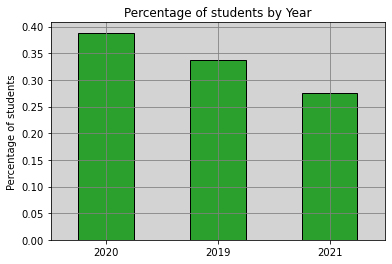

In [28]:
plot_value_counts(df = ib_results, col = 'Year', color = 'tab:green')

##### Comments

- There are no obvious errors in the year column. 
- The largest group of students came from 2020 and the smallest from 2021.

#### Subject Column

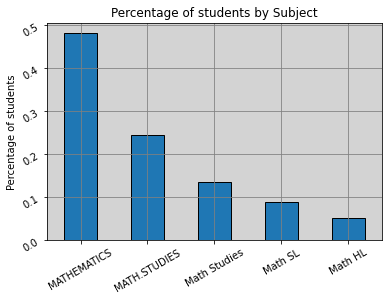

In [29]:
plot_value_counts(df = ib_results, col = 'Subject', color = 'tab:blue', rotation = 30)

##### Comments

- There are no strange values in the Subject column, though the subjects are not written consistently.. 
- Since the names of the courses changed in 2021, the new course names (mostly equivalent courses) will be used. 'MATHEMATICS' will be replaced with 'Math AA'. 'MATH.STUDIES' will be replaced with 'Math AI'.
- Math HL and Math SL will be replaced with Math AA.
- Math Studies will be replaced with Math AI.

In [30]:
ib_results['Subject'] = ib_results['Subject'].apply(lambda x: 'Math AA' 
                                                    if x == 'MATHEMATICS'
                                                    or x == 'Math SL'
                                                    or x == 'Math HL'
                                                    else x)

In [31]:
ib_results['Subject'] = ib_results['Subject'].apply(lambda x: 'Math AI' 
                                                 if x == 'MATH.STUDIES' or x == 'Math Studies' else x)

In [32]:
ib_results.Subject.value_counts()

Math AA    120
Math AI     73
Name: Subject, dtype: int64

#### Level Column

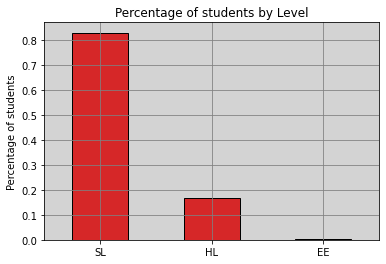

In [33]:
plot_value_counts(df = ib_results, col = 'Level', color = 'tab:red')

- There should only be two levels for math classes - 'SL' and 'HL'.
- EE represents an extended essay in mathematics. These rows need to be dropped because they are not actual class grades.

##### Comments

In [34]:
ib_results = ib_results[ib_results.Level != 'EE']

#### Grade Column

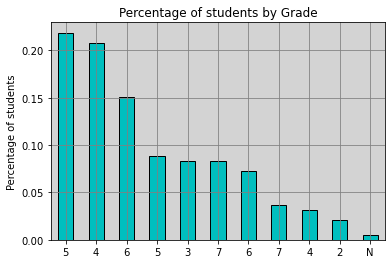

In [35]:
plot_value_counts(df = ib_results, col = 'Grade', color = 'c')

- The row with grade 'N' needs to be dropped.
- There are repeat values. Perhaps some are strings and some are integers.

In [36]:
ib_results = ib_results[ib_results.Grade != 'N']

In [37]:
ib_results['Grade'] = ib_results['Grade'].astype('int')

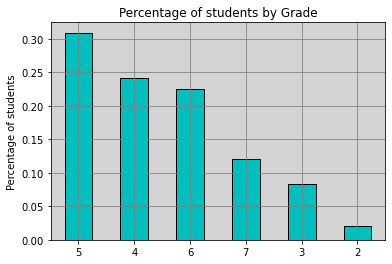

In [38]:
plot_value_counts(df = ib_results, col = 'Grade', color = 'c')

##### Comments

- The largest number of students received a 5.
- Very few students received a 3 or 2, which indicates low failure rates.

## Math Placement Data <a class ="anchor" id = "mathplacement"></a>

[Back to top](#backtotop)

### 2019

#### Info

In [39]:
math_2019 = pd.read_csv(DATA_PATH + MATH_2019)

In [40]:
math_2019.head(2)

,Student,Currently in,Recommended Course,num_ops_1_1,num_ops_2_1,num_ops_3_1,num_ops_4_1,alg_exp_1_1,alg_exp_2_1,alg_exp_3_1,...,quad_4_3,func_6_3,expn_3_1,expn_4_1,expn_5_2,expn_6_2,expn_7_3,expn_8_2,expn_9_3,quad_5_3
0,Student 0,Math HL,Math SL,1,1.0,1,1.0,0.5,0.5,1.0,...,0.0,1.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Student 1,Math HL,Math HL,1,0.0,1,1.0,1.0,1.0,1.0,...,1.0,0.5,1,1.0,1.0,1.0,1.0,1.0,0.5,1.0


In [41]:
math_2019.set_index('Student', inplace = True)

In [42]:
math_2019.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72 entries, Student 0 to nan
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Currently in        64 non-null     object 
 1   Recommended Course  64 non-null     object 
 2   num_ops_1_1         72 non-null     int64  
 3   num_ops_2_1         72 non-null     float64
 4   num_ops_3_1         72 non-null     int64  
 5   num_ops_4_1         72 non-null     float64
 6   alg_exp_1_1         72 non-null     float64
 7   alg_exp_2_1         72 non-null     float64
 8   alg_exp_3_1         72 non-null     float64
 9   alg_exp_4_1         72 non-null     float64
 10  expn_1_1            72 non-null     float64
 11  expn_2_2            72 non-null     float64
 12  num_ops_5_1         72 non-null     float64
 13  linear_1_2          72 non-null     float64
 14  alg_exp_5_2         72 non-null     float64
 15  geom_1_2            72 non-null     float64
 16  linear

##### Comments

- There are 38 columns. All of the columns are numerical except the names of the courses.
- There are categories of questions as indicated by the first part of the column name. 
- The second part of the column name indicates the question number for that skill.
- The third part of the column name indicates the difficulty level of the question.
- Weighted averages will be found for each skill. The weighting will be determined by the difficulty level of the question.

#### Column Distributions

Let's take a look at the grade distribution of each question by level.

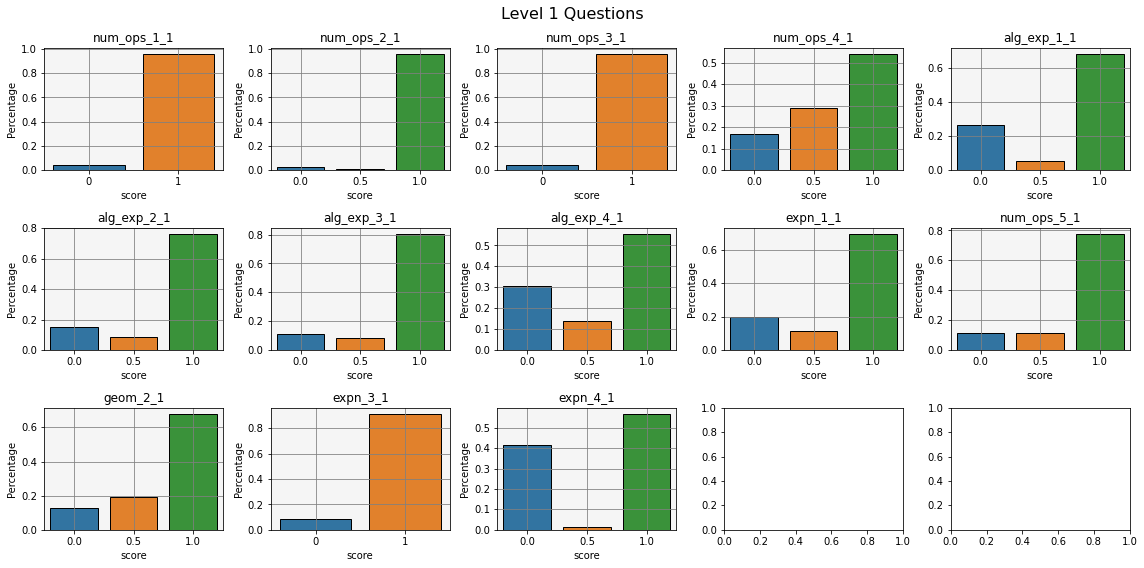

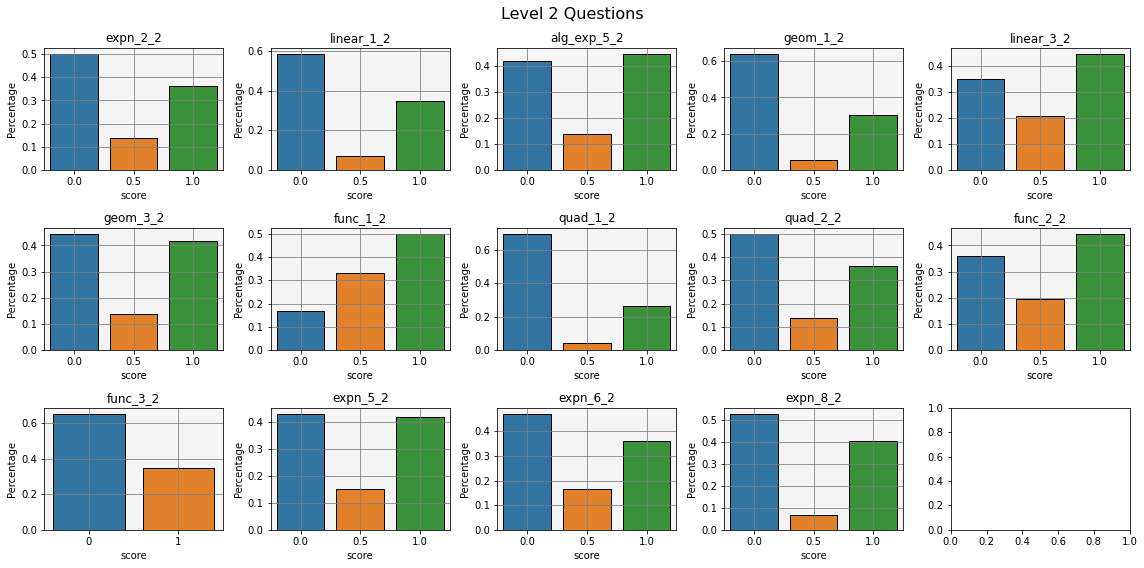

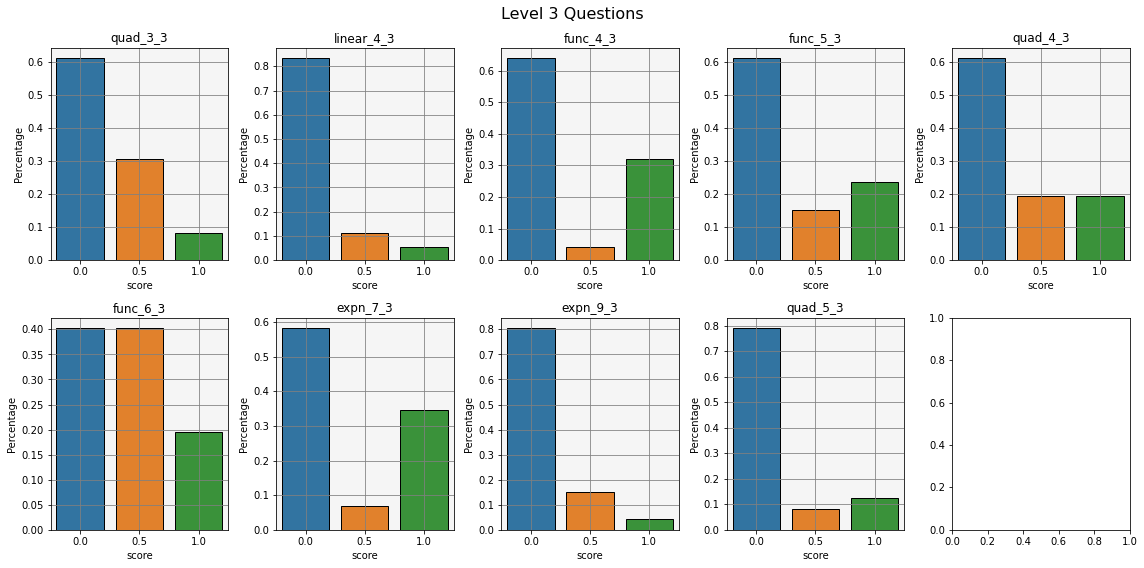

In [43]:
display_question_distributions(df = math_2019, figsize = (16, 8), number_cols = 5)

##### Comments

- As expected, more students received 1 than 0 on the Level 1 questions.
- In level 2, many more students had received a score of 0 than in level 1. 
- In level 3, more students scored 0 than 1.
- Students overall did best on number operation questions.
- There was a much worse performance on quadratic questions, linear, and exponential questions.
- We will combine the questions by topic and give a weighted average according to level. Functions are in the python files.
- For EDA purposes, the year will also be assigned to the DataFrame.

#### Clean DF

In [44]:
math_2019_clean = create_clean_math_df(math_2019)

In [45]:
math_2019_clean['year'] = 2019

In [46]:
math_2019_clean.head(2)

,total_weighted_perc,alg_exp,expn,func,geom,linear,num_ops,quad,level_1_avg,level_2_avg,level_3_avg,year
Student,,,,,,,,,,,,
Student 0,0.463235,0.5,0.117647,0.333333,0.6,0.785714,0.9,0.653846,0.807692,0.428571,0.333333,2019
Student 1,0.816176,1.0,0.911765,0.700000,1.0,0.571429,0.8,0.807692,0.923077,0.964286,0.611111,2019


### 2020

#### Info

In [47]:
math_2020 = pd.read_csv(DATA_PATH + MATH_2020).dropna(axis = 0, how = 'any')

In [48]:
math_2020.head(2)

,Student,Currently in,Recommended Course,num_ops_1_1,num_ops_2_1,num_ops_3_1,alg_exp_1_1,alg_exp_2_1,alg_exp_3_1,expn_1_1,...,func_2_2,func_3_3,func_4_3,func_5_3,expn_4_2,expn_5_2,expn_6_3,expn_7_2,expn_8_3,quad_5_3
0,Student 64,Math HL,Math SL,1.0,1.0,1.0,1.0,1.0,0.5,1.0,...,1.0,0.5,1.0,0.5,0.0,0.0,0.0,0.5,0.0,0.5
1,Student 65,Math SL,Math Studies,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
math_2020.set_index('Student', inplace = True)

In [50]:
math_2020.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74 entries, Student 64 to Student 138
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Currently in        74 non-null     object 
 1   Recommended Course  74 non-null     object 
 2   num_ops_1_1         74 non-null     float64
 3   num_ops_2_1         74 non-null     float64
 4   num_ops_3_1         74 non-null     float64
 5   alg_exp_1_1         74 non-null     float64
 6   alg_exp_2_1         74 non-null     float64
 7   alg_exp_3_1         74 non-null     float64
 8   expn_1_1            74 non-null     float64
 9   expn_2_1            74 non-null     float64
 10  expn_3_2            74 non-null     float64
 11  num_ops_4_1         74 non-null     float64
 12  linear_1_3          74 non-null     float64
 13  linear_2_2          74 non-null     float64
 14  alg_exp_4_2         74 non-null     float64
 15  geom_1_2            74 non-null     float64
 1

- Same comments as in 2019 math data.

#### Column Distributions

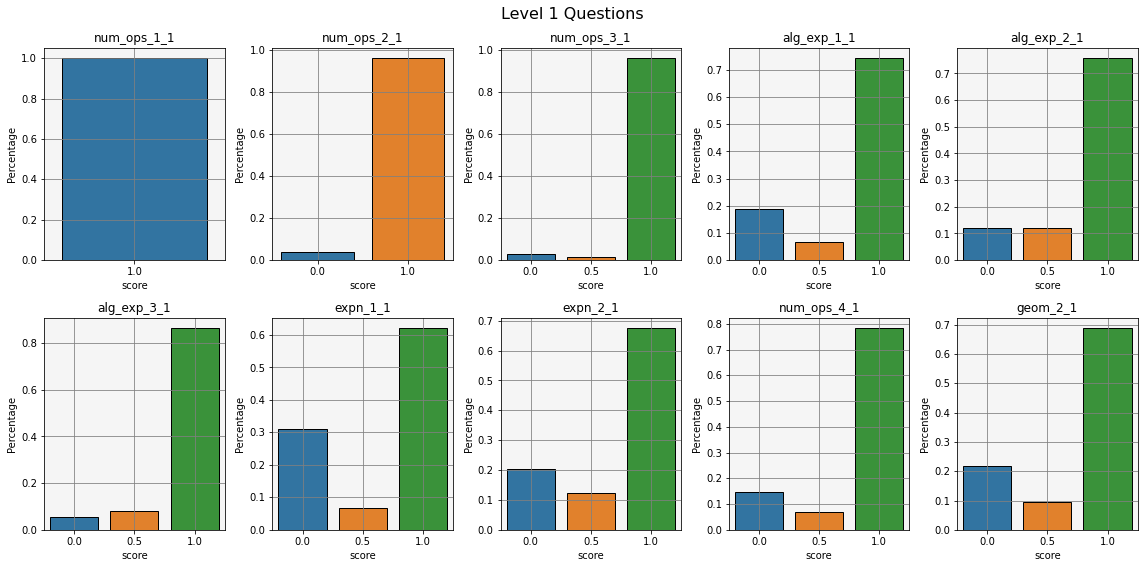

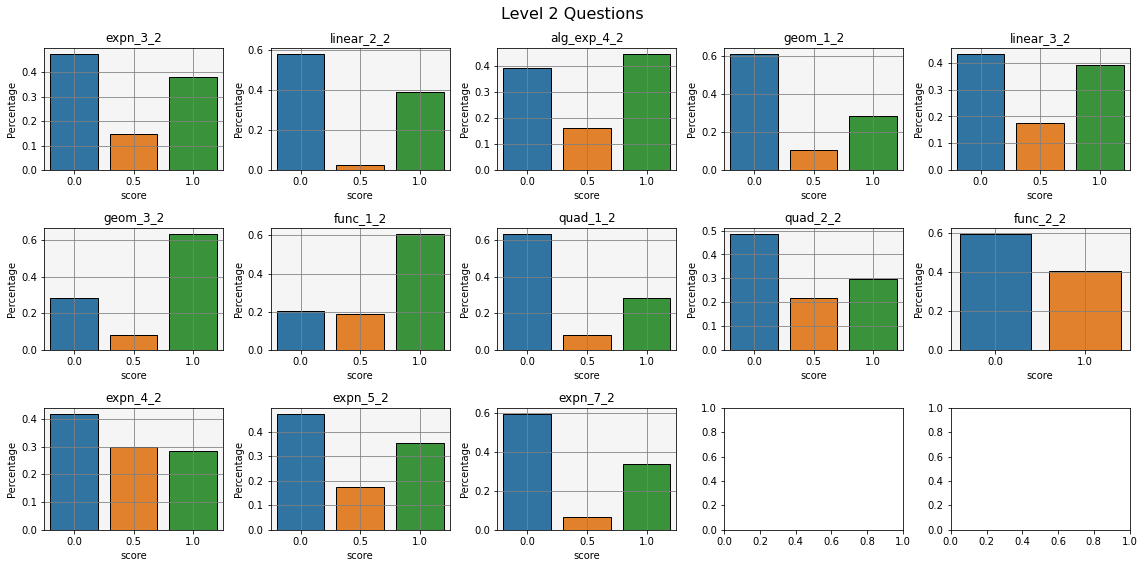

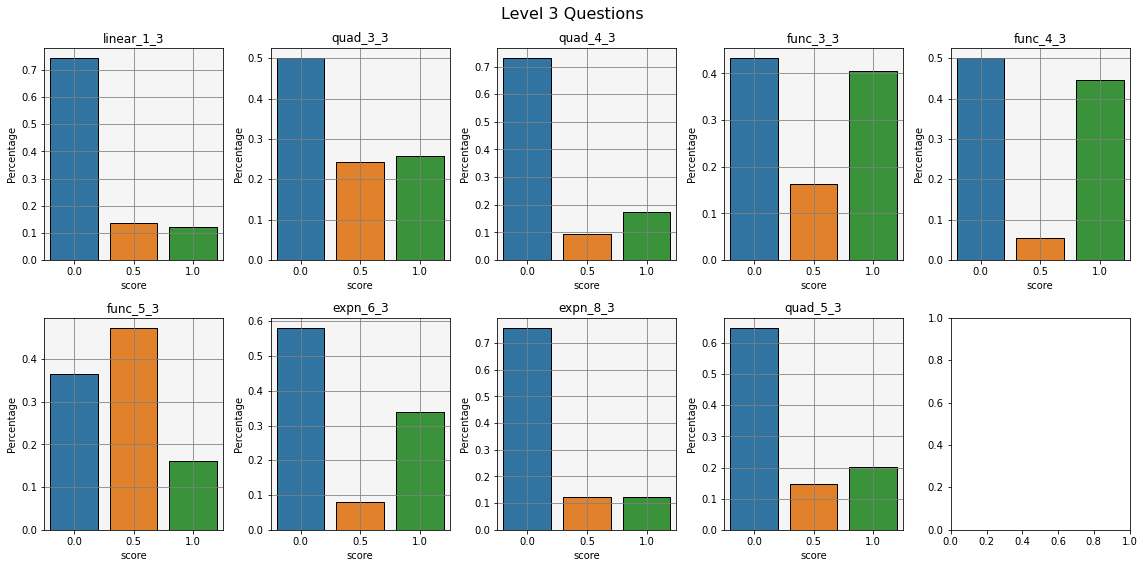

In [51]:
display_question_distributions(df = math_2020, figsize = (16, 8), number_cols = 5)

##### Comments

- Same general comments as math 2019 results.
- The questions of the test do not seem to be identical, though, as there are different columns.
- In order to make the DataFrames mergeable, the questions need to be merged into their respective skills.
- For EDA purposes, the year will also be assigned to the DataFrame.

#### Clean DF

In [52]:
math_2020_clean = create_clean_math_df(math_2020)

In [53]:
math_2020_clean['year'] = 2020

In [54]:
math_2020_clean.head(2)

,total_weighted_perc,alg_exp,expn,func,geom,linear,num_ops,quad,level_1_avg,level_2_avg,level_3_avg,year
Student,,,,,,,,,,,,
Student 64,0.420635,0.5,0.15625,0.769231,0.6,0.571429,0.75,0.115385,0.8,0.423077,0.277778,2020
Student 65,0.246032,0.4,0.06250,0.423077,0.6,0.000000,1.00,0.000000,0.6,0.192308,0.166667,2020


- Now the columns are consistent with math 2019.

### 2021

#### Info

In [55]:
math_2021 = pd.read_csv(DATA_PATH + MATH_2021).dropna(axis = 0, how = 'any')

In [56]:
math_2021.head(2)

,Student,Currently in,Recommended Course,num_ops_1_1,num_ops_2_1,alg_exp_1_1,alg_exp_2_1,alg_exp_3_1,geom_1_1,linear_1_1,...,expn_4_3,expn_5_2,expn_6_3,quad_3_3,func_2_2,func_3_3,func_4_3,quad_4_3,quad_5_3,alg_exp_5_3
0,Student 139,Analysis HL,Analysis SL?,0,1.0,1.0,1.0,0.5,1,1.0,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.5
1,Student 140,Analysis HL,Analysis HL,1,1.0,1.0,1.0,1.0,1,1.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.5,1.0,1.0


In [57]:
math_2021.set_index('Student', inplace = True)

In [58]:
math_2021.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53 entries, Student 139 to Student 191
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Currently in        53 non-null     object 
 1   Recommended Course  53 non-null     object 
 2   num_ops_1_1         53 non-null     int64  
 3   num_ops_2_1         53 non-null     float64
 4   alg_exp_1_1         53 non-null     float64
 5   alg_exp_2_1         53 non-null     float64
 6   alg_exp_3_1         53 non-null     float64
 7   geom_1_1            53 non-null     int64  
 8   linear_1_1          53 non-null     float64
 9   num_ops_3_1         53 non-null     float64
 10  num_ops_4_1         53 non-null     float64
 11  expn_1_1            53 non-null     float64
 12  linear_2_2          53 non-null     float64
 13  geom_2_1            53 non-null     float64
 14  geom_3_2            53 non-null     float64
 15  geom_4_2            53 non-null     float64
 

- Same comments as the previous two data frames, though there are three less columns. The column names are not identical, so they will need to be aggregated into skills.

#### Column Distributions

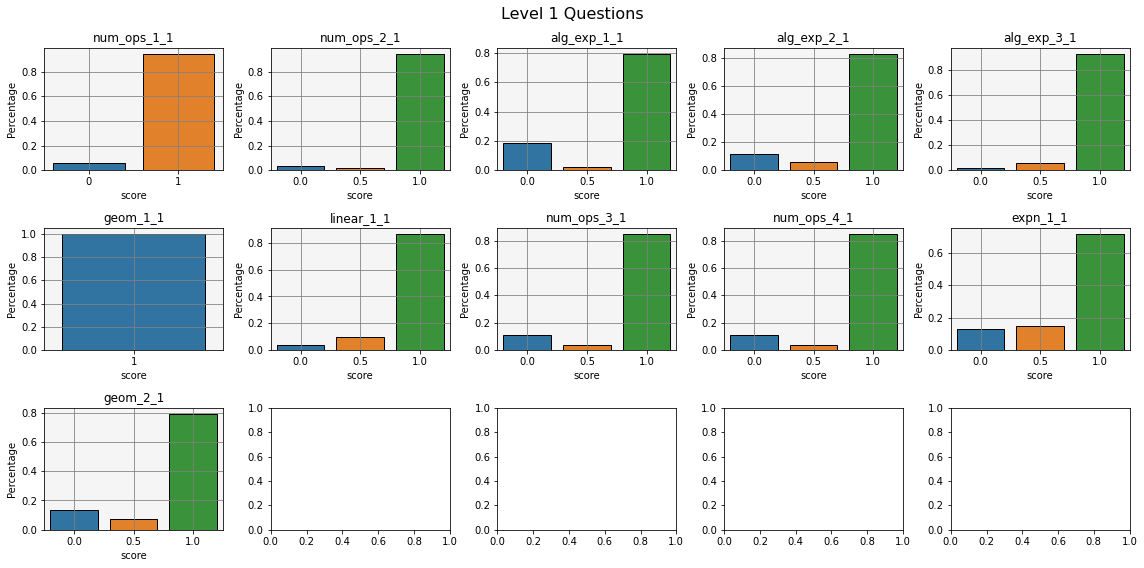

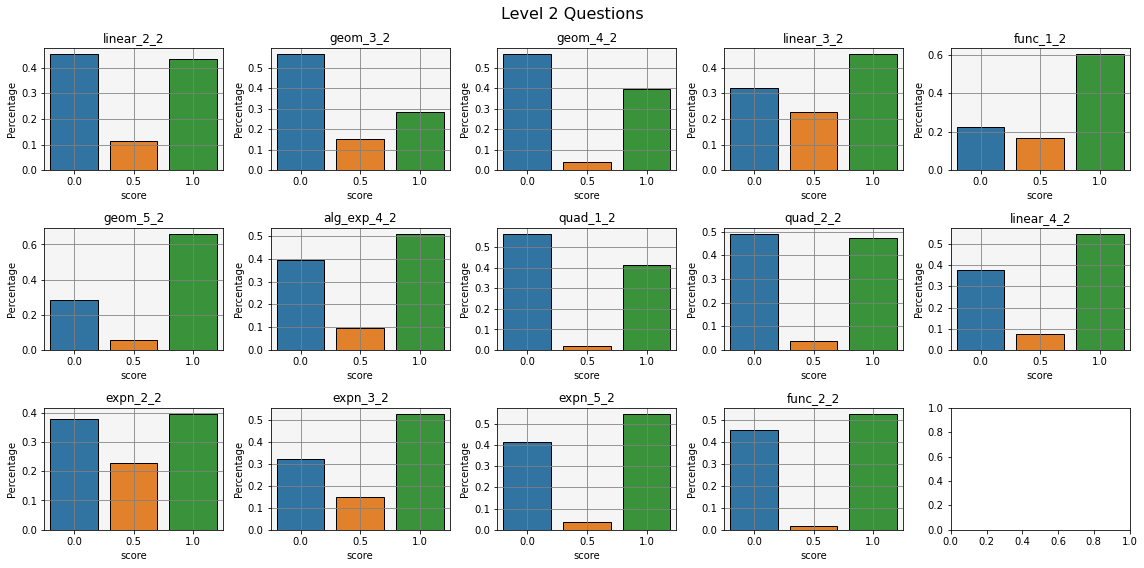

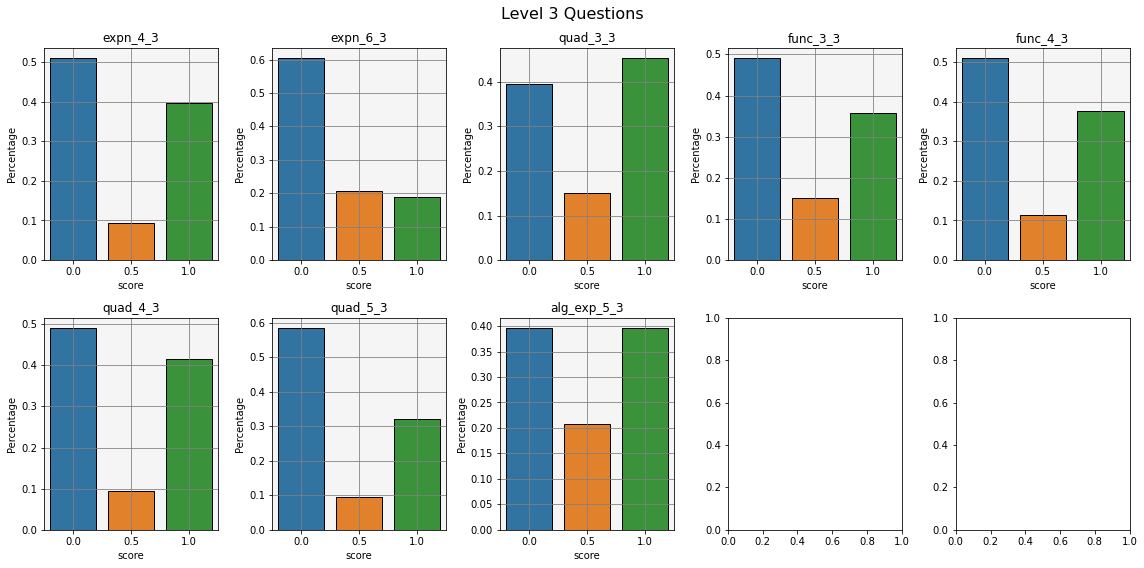

In [59]:
display_question_distributions(df = math_2021, figsize = (16, 8), number_cols = 5)

##### Comments

- Same comments as above.
- Questions will be merged into their respective skills.
- Year column will be assigned for EDA purposes.

#### Clean DF

In [60]:
math_2021_clean = create_clean_math_df(math_2021)

In [61]:
math_2021_clean['year'] = 2021

In [62]:
math_2021_clean.head(2)

,total_weighted_perc,alg_exp,expn,func,geom,linear,num_ops,quad,level_1_avg,level_2_avg,level_3_avg,year
Student,,,,,,,,,,,,
Student 139,0.746032,0.5,0.692308,1.0,1.0,0.714286,0.75,0.615385,0.863636,0.750000,0.6875,2021
Student 140,0.833333,1.0,0.615385,0.9,1.0,1.000000,1.00,0.653846,1.000000,0.892857,0.6875,2021


### Merging Data Frames

In [63]:
math_clean = pd.concat([math_2019_clean, math_2020_clean, math_2021_clean],axis = 0)

- We will check the distribution of grades by each year.

In [64]:
rel_cols = math_clean.drop(['year'], axis = 1).columns

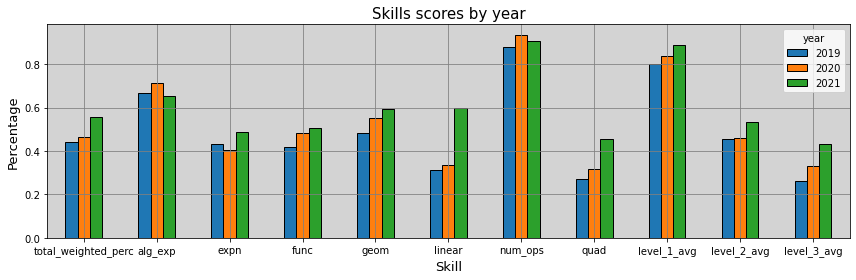

In [65]:
fig, axs = plt.subplots(figsize = (12, 4))
math_clean.groupby('year')[rel_cols].mean().transpose().plot(kind = 'bar', edgecolor = 'Black', ax = axs)
axs.set_title('Skills scores by year', fontsize = 15)
axs.set_xlabel('Skill', fontsize = 13)
axs.set_ylabel('Percentage', fontsize = 13)
axs.grid(color = 'grey')
axs.tick_params(rotation = 0)
axs.set_facecolor('lightgrey')
plt.tight_layout()
plt.show()

- The class of 2021 seems to be slightly stronger in many of the math skills.
- The class of 2019 seems to have the most difficulty with the skills. Though perhaps there was a slight difference in difficulty level of the placement tests.

## Merging IB and Math Results <a class ="anchor" id = "mergingresults"></a>

[Back to top](#backtotop)

In [66]:
math_clean.head(2)

,total_weighted_perc,alg_exp,expn,func,geom,linear,num_ops,quad,level_1_avg,level_2_avg,level_3_avg,year
Student,,,,,,,,,,,,
Student 0,0.463235,0.5,0.117647,0.333333,0.6,0.785714,0.9,0.653846,0.807692,0.428571,0.333333,2019
Student 1,0.816176,1.0,0.911765,0.700000,1.0,0.571429,0.8,0.807692,0.923077,0.964286,0.611111,2019


In [67]:
ib_results.head(2)

,Year,Subject,Level,Grade
Student,,,,
Student 33,2019,Math AI,SL,6
Student 37,2019,Math AI,SL,6


- Combine the data into one overall dataframe.

In [68]:
all_df = math_clean.merge(ib_results[['Subject', 'Level', 'Grade']], 
                          how = 'outer', 
                          left_index = True,
                         right_index = True)

In [69]:
all_df = all_df.dropna(axis = 0, how = 'any')

- The DataFrames are now merged and contain all the complete information.
- We will perform EDA in the next section, but first we need to label the appropriate classes.

## Labeling appropriate class <a class ="anchor" id = "labelingclass"></a>

[Back to top](#backtotop)

Criteria:
- If students scored a 5-7 in Math AA HL, they are a good fit for Math AA HL. (Grades 4 and under will be considered a good fit for Math AA SL).
- If students scored a 4-7 in Math AA SL, the are a good fit for Math AA SL. (Grades 3 and under will be considered a good fit for Math AI SL).
- If students scored a 7 in Math AI SL, it means they also could have been a good fit for Math AA SL.

To summarize:
1. Math AA HL: Students in Math AA HL who received $\ge 5$
2. Math AA SL: Students in Math AA HL who received $\le 4$, Students in Math AA SL who received $\ge 4$.
3. Math AI SL: Students in Math AA SL who received $\le 3$, Students in Math AI SL who received $<7$. 

In [70]:
all_df['true_class'] = ib_results.apply(label_class, axis = 1)

In [71]:
all_df.head(5)

,total_weighted_perc,alg_exp,expn,func,geom,linear,num_ops,quad,level_1_avg,level_2_avg,level_3_avg,year,Subject,Level,Grade,true_class
Student,,,,,,,,,,,,,,,,
Student 0,0.463235,0.500000,0.117647,0.333333,0.6,0.785714,0.9,0.653846,0.807692,0.428571,0.333333,2019.0,Math AA,SL,6.0,Math AA SL
Student 1,0.816176,1.000000,0.911765,0.700000,1.0,0.571429,0.8,0.807692,0.923077,0.964286,0.611111,2019.0,Math AA,HL,5.0,Math AA HL
Student 10,0.492647,0.916667,0.617647,0.566667,0.6,0.000000,0.9,0.115385,0.923077,0.392857,0.388889,2019.0,Math AI,SL,3.0,Math AI SL
Student 100,0.523810,1.000000,0.500000,0.384615,0.8,0.285714,1.0,0.384615,0.900000,0.576923,0.333333,2020.0,Math AA,SL,3.0,Math AI SL
Student 101,0.849206,1.000000,0.843750,1.000000,0.8,0.857143,1.0,0.615385,1.000000,0.807692,0.833333,2020.0,Math AA,HL,5.0,Math AA HL


In [72]:
all_df.true_class.value_counts(normalize = True)

Math AA SL    0.500000
Math AI SL    0.357895
Math AA HL    0.142105
Name: true_class, dtype: float64

The above seems consistent with the world distribution of students, which is illustrated in the image below from 2020.

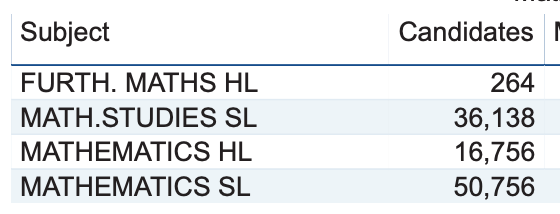

# EDA <a class ="anchor" id = "edadata"></a>

[Back to top](#backtotop)

## Split the data into train and test set <a class ="anchor" id = "splitdata"></a>

[Back to top](#backtotop)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(all_df[rel_cols],
                                                    all_df['true_class'], 
                                                    test_size = 0.2,
                                                    stratify = all_df['true_class'],
                                                    random_state = 1234)

In [74]:
X_train.columns = X_train.columns.astype('str')
X_test.columns = X_test.columns.astype('str')

In [75]:
print('Distribution of labels for the train set:\n{}\n'
      .format(y_train.value_counts(normalize = True)))

print('Distribution of labels for the test set:\n{}' 
      .format(y_test.value_counts(normalize = True)))

Distribution of labels for the train set:
Math AA SL    0.500000
Math AI SL    0.355263
Math AA HL    0.144737
Name: true_class, dtype: float64

Distribution of labels for the test set:
Math AA SL    0.500000
Math AI SL    0.368421
Math AA HL    0.131579
Name: true_class, dtype: float64


In [76]:
all_df_train = all_df.loc[X_train.index]
all_df_test = all_df.loc[X_test.index]

**Comments**

- The label distributions are consistent between the train and test set.

## Label Distribution <a class ="anchor" id = "label"></a>

[Back to top](#backtotop)

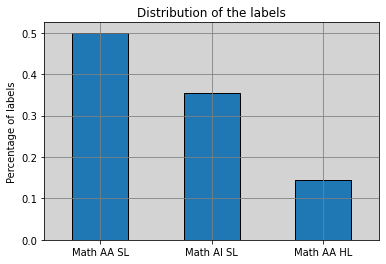

In [77]:
fig, axs = plt.subplots()
all_df_train.true_class.value_counts(normalize = True).plot(kind = 'bar', edgecolor = 'Black')
axs.set_ylabel('Percentage of labels')
axs.set_title('Distribution of the labels')
axs.grid(color = 'grey')
axs.tick_params(rotation = 0)
axs.set_facecolor('lightgrey')
plt.show()

**Comments**

- There is a heavy class imbalance (which we saw above). 
- The majority of students are in Math AA SL. 
- Very few are in Math AA HL. 
- This will affect the model, so it will be important to account for this class imbalance by weighting the model accordingly.

## Checking for outliers in each skill <a class ="anchor" id = "outliers"></a>

[Back to top](#backtotop)

In [78]:
numeric_cols = all_df_train.columns[all_df_train.dtypes != 'object']

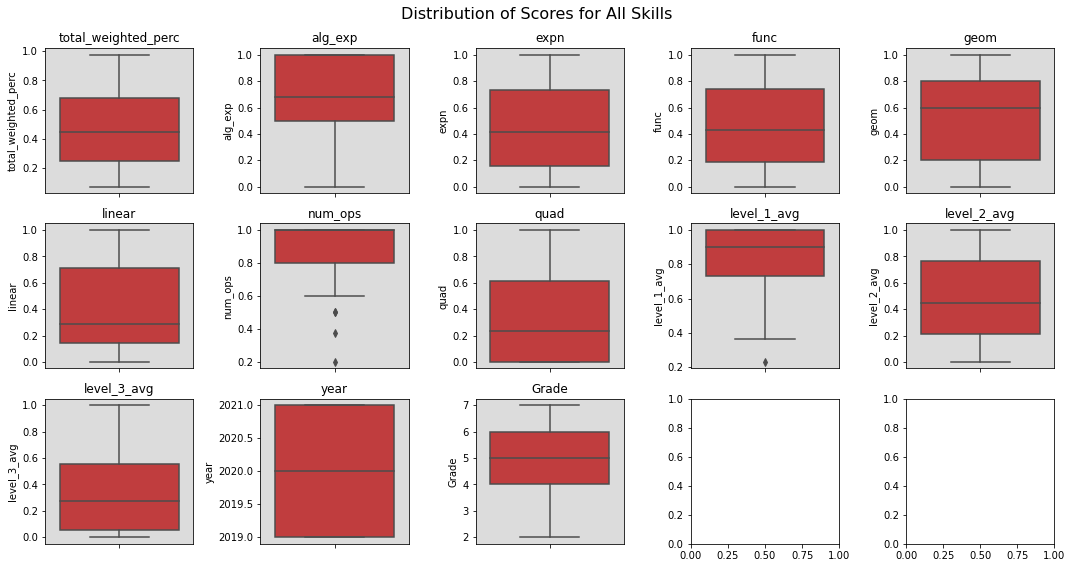

In [79]:
n_rows = 3
n_cols = 5
fig, axs = plt.subplots(n_rows, n_cols, figsize = (15, 8))

for idx, col in enumerate(numeric_cols):
    axs_idx = (idx// n_cols, idx % n_cols)
    sns.boxplot(y = col, data = all_df_train, ax = axs[axs_idx], color = 'tab:red')
    axs[axs_idx].set_title(col)
    axs[axs_idx].set_facecolor('gainsboro')
plt.tight_layout()
plt.suptitle('Distribution of Scores for All Skills', fontsize = 16)
plt.tight_layout()
plt.show()

**Comments**

- Most students did well on num_ops and alg_exp.
- Much fewer students did well on quadraics questions, and level 3 questions in general.


## Subject vs. score on skills <a class ="anchor" id = "subjectvsskill"></a>

[Back to top](#backtotop)

In [80]:
NUM_COLS_SUB = 4

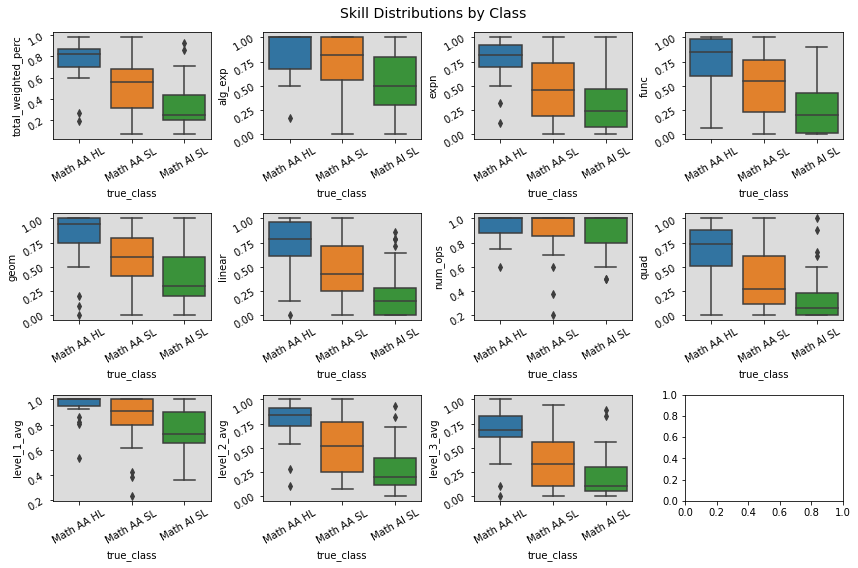

In [81]:
fig, axs = plt.subplots(len(rel_cols)// NUM_COLS_SUB + 1, NUM_COLS_SUB, figsize = (12, 8))
for idx, skill in enumerate(rel_cols):
    axs_idx = (idx// NUM_COLS_SUB, idx % NUM_COLS_SUB)
    sns.boxplot(x = 'true_class', 
                y = skill, 
                data = all_df_train, 
                order = ['Math AA HL', 'Math AA SL', 'Math AI SL'], 
                ax = axs[axs_idx])
    axs[axs_idx].set_facecolor('gainsboro')
    axs[axs_idx].tick_params(rotation = 30)
plt.suptitle('Skill Distributions by Class', fontsize = 14)
plt.tight_layout()
plt.show()

**Comments**

- Grade distributions between the classes were mostly high for num_ops. 
- The rest of the skills have a clear descension between Math AA HL, Math AA SL, and Math AI SL students. This indicates that the placement test reflects well the ranges of strengths amongst the classes.

## Correlation between skills <a class ="anchor" id = "corrbtwnskills"></a>

[Back to top](#backtotop)

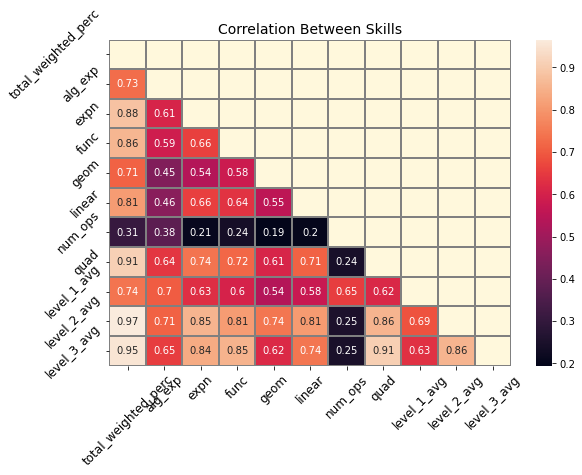

In [82]:
fig, axs = plt.subplots(figsize = (9, 6))
mask = np.triu(np.ones_like(all_df_train[['total_weighted_perc', 
                                          'alg_exp', 'expn', 'func',
                                          'geom', 'linear', 'num_ops', 
                                          'quad', 'level_1_avg',
                                         'level_2_avg', 'level_3_avg']].corr()))
sns.heatmap(all_df_train[['total_weighted_perc', 
                          'alg_exp', 'expn', 'func',
                          'geom', 'linear', 'num_ops', 
                          'quad', 'level_1_avg',
                          'level_2_avg', 'level_3_avg']].corr(), 
            annot = True, 
            mask = mask,
            linecolor = 'grey',
            linewidths=.01,
            ax = axs)
axs.set_title('Correlation Between Skills', fontsize = 14)
axs.tick_params(rotation = 45, labelsize = 'large')
axs.set_facecolor('cornsilk')

<b> Comments </b>
1. Many of the features are correlated with total_weighted_perc. While this is a relevant column for model prediction, this feature presumably won't add much that level_2_avg and level_3_avg do not already add. Thus this feature will be dropped. It will also make for more interesting features when doing feature importance.
2. We will potentially drop the averages by level to have more interesting features, based on skills. But this will be tested first to see if we can still get accurate predictions without them.
3. Between skills, quadratics and exponents are the highest correlated.
4. Lastly, quadratics is the highest correlated skill to level 2 and level 3 averages. This is not surprising as quadratics make up a larger portion of level 2 and level 3 questions.

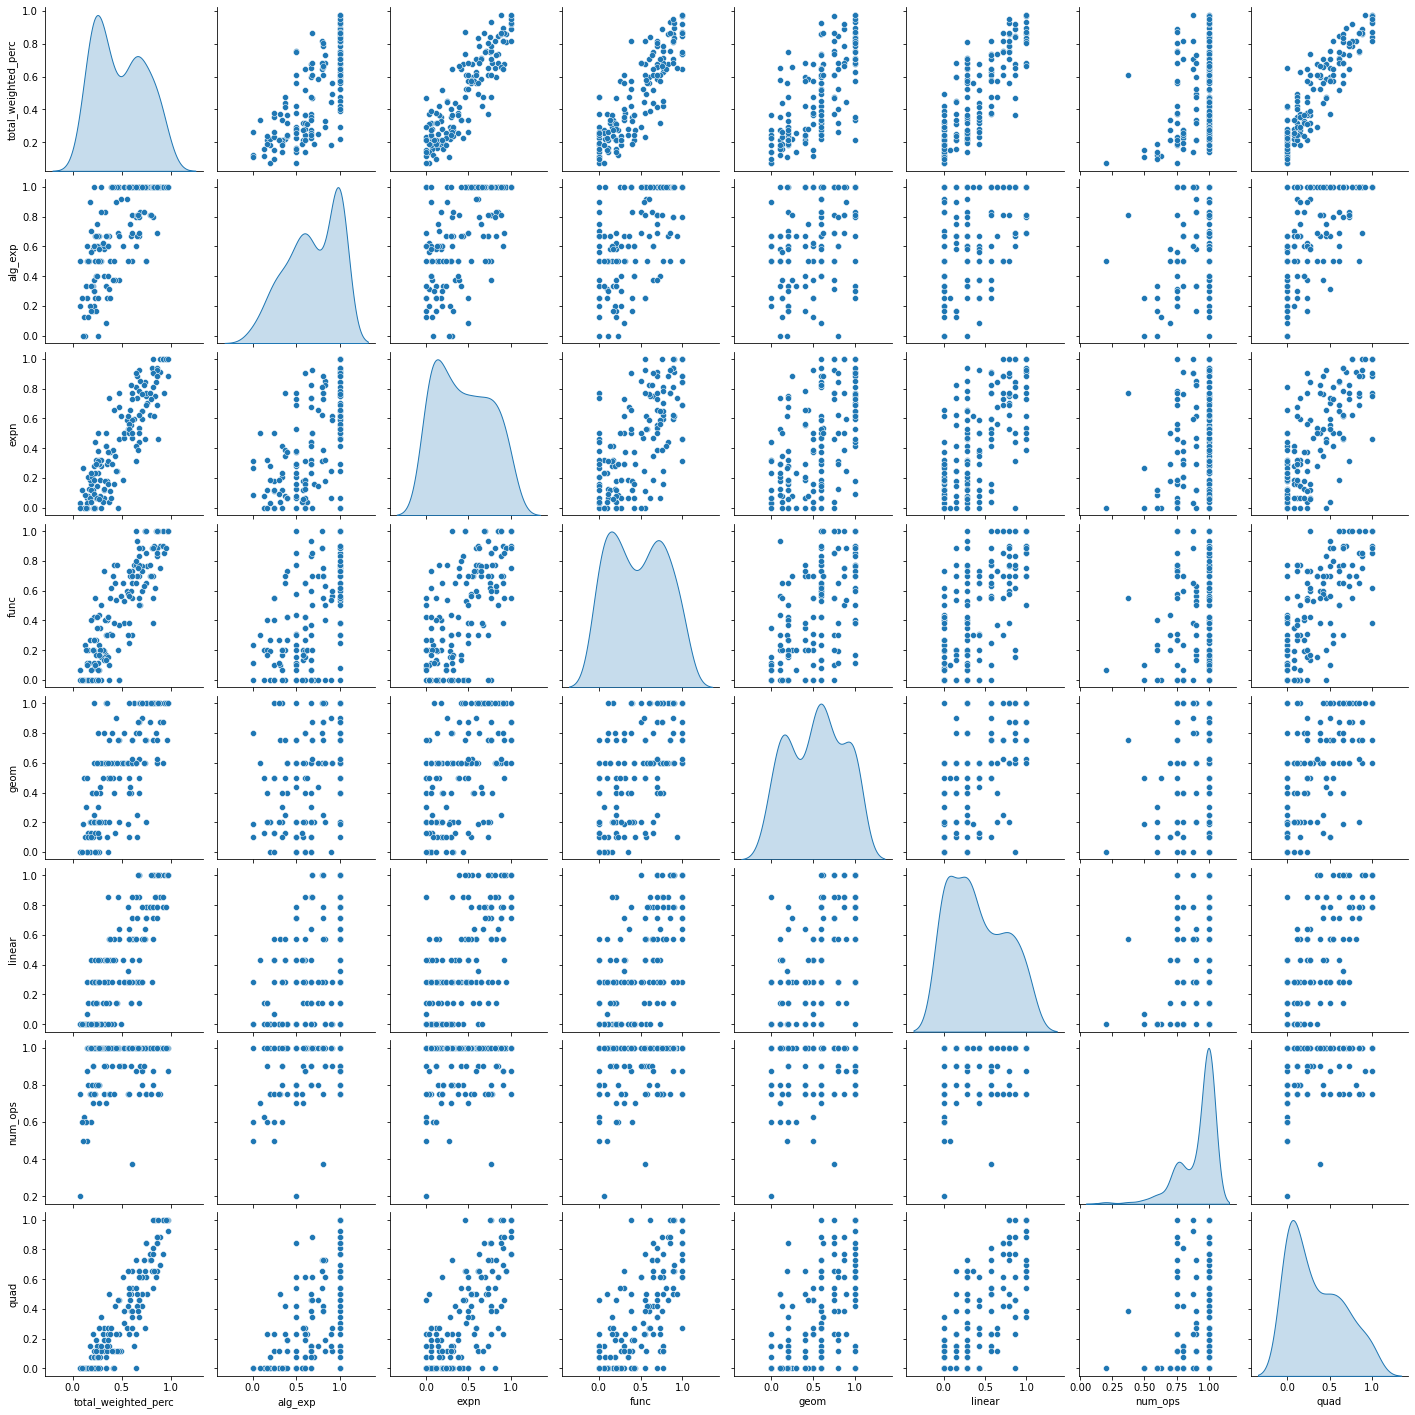

In [83]:
sns.pairplot(all_df_train[['total_weighted_perc', 'alg_exp', 'expn', 'func',
                           'geom', 'linear', 'num_ops', 'quad']],
             diag_kind='kde')

**Comments**

- All of the features are positively correlated. This is because students who are generally skilled in math will do better on each of the skills.
- Num ops has much lower positive correlation, because these questions were fairly simple and most students did well.

### Create different feature sets (removing correlated features)

In [84]:
X_train_no_ttl = X_train.drop(['total_weighted_perc'],axis = 1)
X_test_no_ttl = X_test.drop(['total_weighted_perc'], axis = 1)

In [85]:
X_train_no_lvl = X_train.drop(['level_1_avg',
                              'level_2_avg',
                              'level_3_avg'],axis = 1)
X_test_no_lvl = X_test.drop(['level_1_avg',
                              'level_2_avg',
                              'level_3_avg'], axis = 1)

In [86]:
X_train_no_ttl_lvl = X_train.drop(['total_weighted_perc',
                                   'level_1_avg',
                              'level_2_avg',
                              'level_3_avg'],axis = 1)
X_test_no_ttl_lvl = X_test.drop(['total_weighted_perc',
                                 'level_1_avg',
                              'level_2_avg',
                              'level_3_avg'], axis = 1)

In [87]:
features_dict = {'Full dataset': X_train,
                 'No total': X_train_no_ttl,
                'No levels': X_train_no_lvl,
                'No total or levels': X_train_no_ttl_lvl}

### Run feature sets on basic un-tuned models

**Logistic Regression**

In [88]:
lr_model = LogisticRegression(class_weight = 'balanced',random_state = 1234)

In [89]:
datasets = []
lr_train_mean = []
lr_val_mean = []
lr_train_std = []
lr_val_std = []
for name, train in features_dict.items():
    datasets.append(name)
    train_mean, val_mean, train_std, val_std = cross_validate_model(lr_model, train, y_train, scorer = 'f1_weighted', plot = False, verbose = False, std = True)
    lr_train_mean.append(train_mean)
    lr_val_mean.append(val_mean)
    lr_train_std.append(train_std)
    lr_val_std.append(val_std)

**Random Forest**

In [90]:
rf_model = RandomForestClassifier(min_samples_leaf = 10,
                                  class_weight = 'balanced',
                                  random_state = 1234)

In [91]:
rf_train_mean = []
rf_val_mean = []
rf_train_std = []
rf_val_std = []
for name, train in features_dict.items():
    train_mean, val_mean, train_std, val_std = cross_validate_model(rf_model, train, y_train, scorer = 'f1_weighted', plot = False, verbose = False, std = True)
    rf_train_mean.append(train_mean)
    rf_val_mean.append(val_mean)
    rf_train_std.append(train_std)
    rf_val_std.append(val_std)

In [92]:
feature_results = pd.DataFrame({'lr_train_mean': lr_train_mean, 
                                'lr_val_mean':lr_val_mean,
                                'lr_train_std':lr_train_std, 
                                'lr_val_std': lr_val_std,
                                 'rf_train_mean': rf_train_mean, 
                                'rf_val_mean': rf_val_mean,
                               'rf_train_std':rf_train_std,
                               'rf_val_std':rf_val_std}, index = datasets)

<AxesSubplot:>

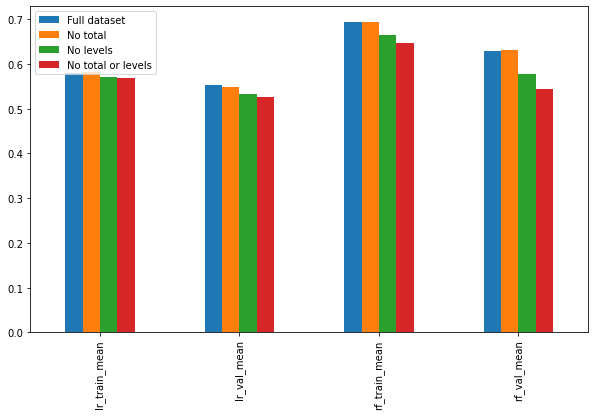

In [93]:
(feature_results[[x for x in feature_results.columns if 'mean' in x]]
 .T.plot(kind = 'bar', figsize = (10, 6)))

In [94]:
feature_results[[x for x in feature_results.columns if 'std' in x]]

,lr_train_std,lr_val_std,rf_train_std,rf_val_std
Full dataset,0.016592,0.084752,0.029137,0.031828
No total,0.019602,0.078282,0.023360,0.033528
No levels,0.018335,0.097441,0.013384,0.079143
No total or levels,0.022930,0.089675,0.012353,0.080599


**Comments**

- As can be seen from the above results, dropping only the totals column produces the best results. The mean f1_scores after the totals column are mostly the same as the full dataset. The standard deviations of the cross-validated f1-scores are also smaller than most of the others.
- Dropping the levels column reduces performance on the validation sets, especially for the random forest model. Thus, it will be important to keep the levels columns for predicitve purposes. These will also be relevant features, though they are not specifically about named mathematics skills.

### Finalizing features

In [95]:
X_train = X_train.drop(['total_weighted_perc'],axis = 1)
X_test = X_test.drop(['total_weighted_perc'], axis = 1)

In [96]:
pickle.dump(X_train, open('../ready_model/X_train_10_6.pkl', 'wb'))
pickle.dump(y_train,open('../ready_model/y_train_10_6.pkl', 'wb'))

## Split into Train and Validation Sets
(For model analysis before model selection)

In [97]:
X_train_sm, X_val, y_train_sm, y_val = train_test_split(X_train,
                                                        y_train, 
                                                        test_size = 0.2,
                                                        stratify = y_train,
                                                        random_state = 1234)

In [98]:
X_train_sm.columns = X_train_sm.columns.astype('str')
X_val.columns = X_val.columns.astype('str')

In [99]:
print('Distribution of labels for the small train set:\n{}\n'
      .format(y_train_sm.value_counts(normalize = True)))

print('Distribution of labels for the validation set:\n{}' 
      .format(y_val.value_counts(normalize = True)))

Distribution of labels for the small train set:
Math AA SL    0.495868
Math AI SL    0.355372
Math AA HL    0.148760
Name: true_class, dtype: float64

Distribution of labels for the validation set:
Math AA SL    0.516129
Math AI SL    0.354839
Math AA HL    0.129032
Name: true_class, dtype: float64


- The distribution of labels between the small train/validation sets are similar, but not exact.

## Sanity Check Results Validation Set

- The naive predictor would be to assign 'Math SL' to every label since it is the largest class.
- The results of this are given below on the validation set.

In [100]:
all_df_val = all_df.loc[X_val.index]

In [101]:
y_pred_val_sanity = pd.Series(['Math AA SL']*len(y_val), index = X_val.index)

In [102]:
sanity_val_error_df = create_error_df(all_df_val, X_val, 
                                      all_df_val.true_class, 
                                      y_pred_val_sanity, 
                                      model_type = 'clustering')

--------------------F1-score: 0.351, Precision score: 0.266, Recall score 0.516--------------------



/Users/hannahlang/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


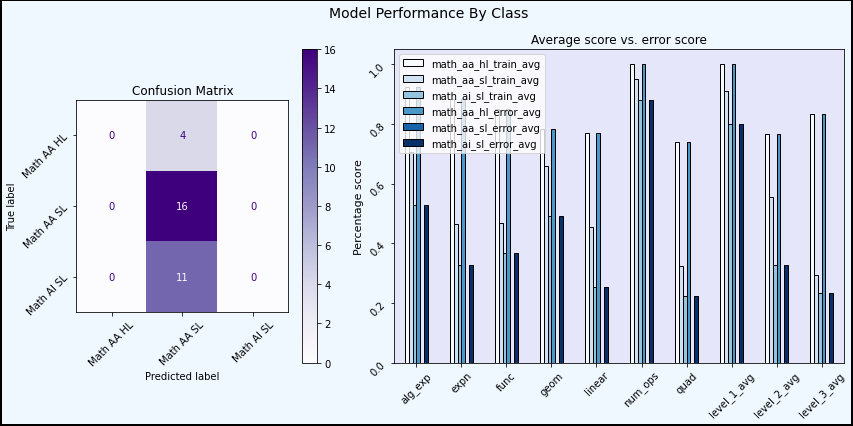

In [103]:
analyze_errors_by_class(all_df_val, 
                        sanity_val_error_df, 
                        X_val, 
                        y_val, 
                        y_pred_val_sanity)

**Comments**

- When we label every sample as "Math SL", the precision score is low and the recall score is higher, which is expected.
- Our minimum baseline performance is an F1 score on the validation set of 0.351

# Clustering <a class = "anchor" id = "clustering"></a>

[Back to top](#backtotop)

## Visualizing clusters with PCA <a class = "anchor" id = "pca"></a>

[Back to top](#backtotop)

In [104]:
pca = PCA(3)

In [105]:
PCA_X = pca.fit_transform(X_train)

In [106]:
pca.explained_variance_ratio_

array([0.70995956, 0.07148677, 0.06300157])

In [107]:
print('Explained variance with three dimensions: {:.2%}'
      .format(pca.explained_variance_ratio_.sum()))

Explained variance with three dimensions: 84.44%


In [108]:
kmeans_model = KMeans(n_clusters = 3)

In [109]:
all_df_train['pca_clusters'] = kmeans_model.fit_predict(PCA_X)

In [110]:
all_df_train.head(2)

,total_weighted_perc,alg_exp,expn,func,geom,linear,num_ops,quad,level_1_avg,level_2_avg,level_3_avg,year,Subject,Level,Grade,true_class,pca_clusters
Student,,,,,,,,,,,,,,,,,
Student 166,0.119048,0.125000,0.000000,0.000000,0.5,0.000000,0.625,0.0,0.500000,0.071429,0.000000,2021.0,Math AI,SL,5.0,Math AI SL,0
Student 2,0.338235,0.333333,0.411765,0.166667,1.0,0.285714,0.900,0.0,0.653846,0.464286,0.055556,2019.0,Math AA,SL,3.0,Math AI SL,0


**3D visualization of clusters**

Since the first three principal components make up 85% of the variance, the visualization of the clusters should be fairly accurate.

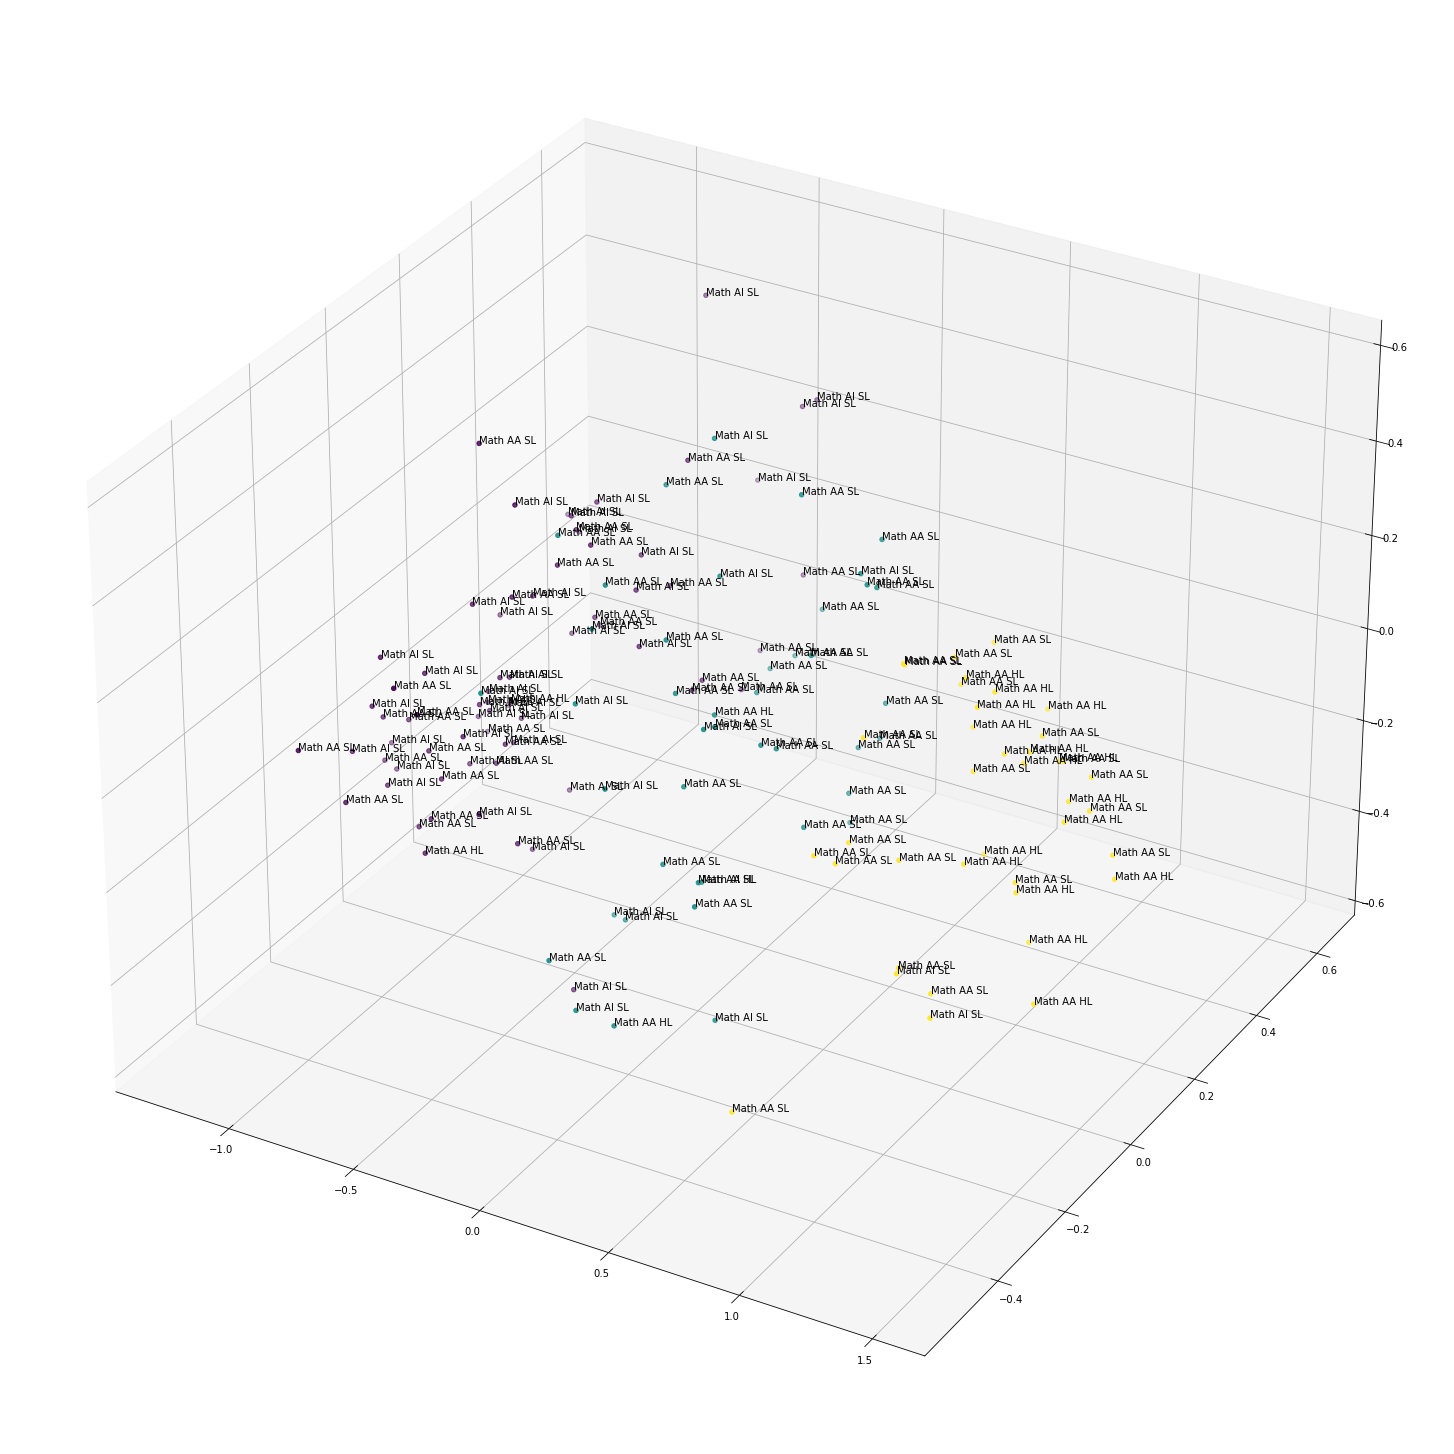

In [111]:
x_coor = PCA_X[:,0]
y_coor = PCA_X[:,1]
z_coor = PCA_X[:, 2]
labels = all_df_train.true_class.values

fig = plt.figure(figsize = (20, 20))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.scatter(x_coor, y_coor, z_coor, c=all_df_train['pca_clusters'])

for i, txt in enumerate(labels):
    ax.text(x_coor[i], y_coor[i], z_coor[i], s = txt)
plt.show()

- Cluster labels are given by the color, actual labels are given in words.
- 3D visualization makes it difficult to see the clusters.
- We will try 2D clusters.

**2D visualization of clusters**

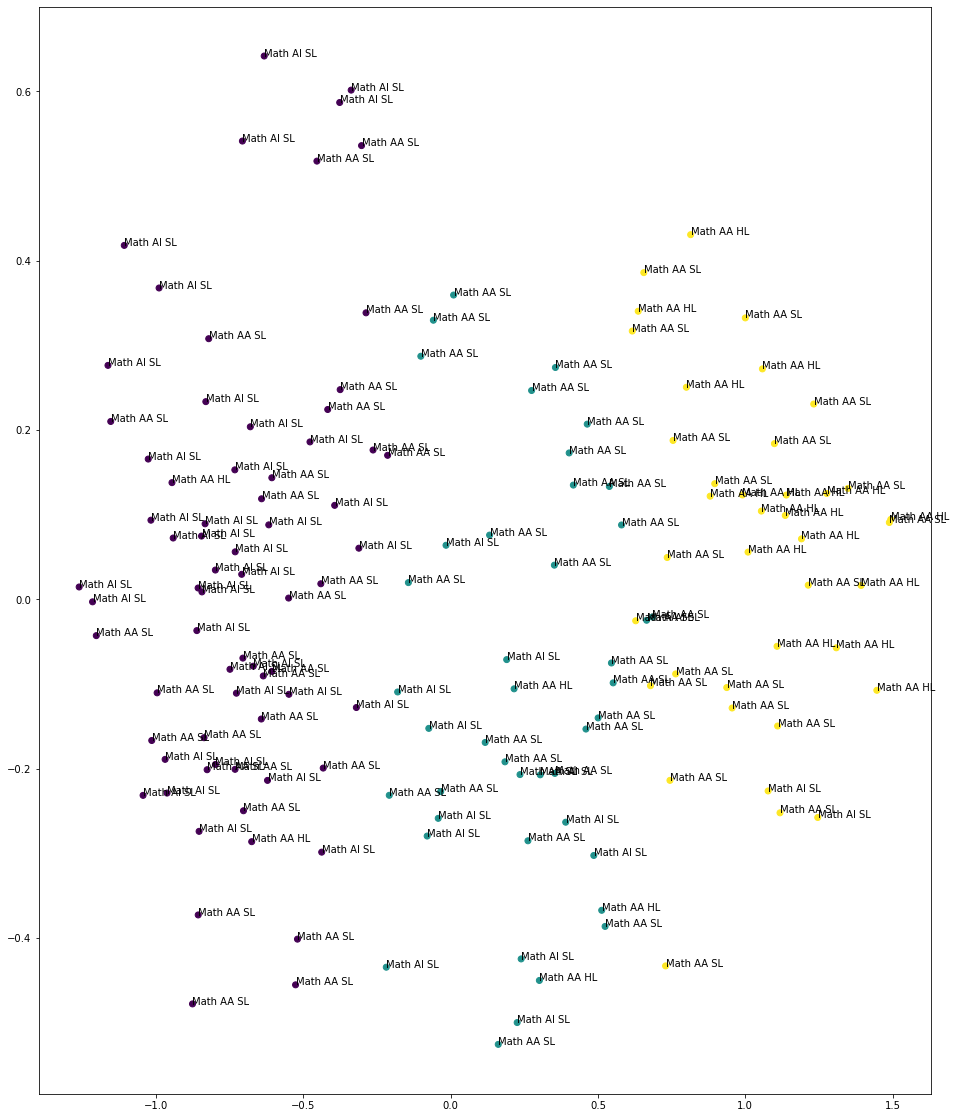

In [112]:
labels = all_df_train.true_class.values

fig, ax = plt.subplots(figsize = (16, 20))
ax.scatter(x_coor, y_coor, c=all_df_train['pca_clusters'])

for i, txt in enumerate(labels):
    ax.text(x_coor[i], y_coor[i], s = txt)
plt.show()

<b> Comments </b>
- As can be seen in the 2D representation of the data, the clusters are not clearly defined. This will affect the performance of the model, since the distinctions are not very clear.
- The Math AI SL label is in green, but many of the true labels in this cluster are actually Math AA SL. Some are even Math AA HL.
- The Math AA SL label is in purple. There are also many labels in this cluster that are actually Math Studies.
- The Math AA HL label is in yellow. Some labels in this cluster are also Math AA SL and Math AI SL.
- The middle cluster is more sparse than the other two clusters.

- Regarding clustering methods, Kmeans will be a more appropriate clustering method than DBSCAN, because the clusters are not very clearly separate from one another. If epsilon is too large, there will only be one cluster. If epsilon is too small, many of the data points will be considered as "noise".

## KMeans <a class = "anchor" id = "kmeans"></a>

[Back to top](#backtotop)

In [113]:
kmeans_model = KMeans(n_clusters = 3, random_state = 1234)

In [114]:
kmeans_model.fit(X_train)

KMeans(n_clusters=3, random_state=1234)

In [115]:
all_df_train['kmeans_cluster'] = kmeans_model.predict(X_train)

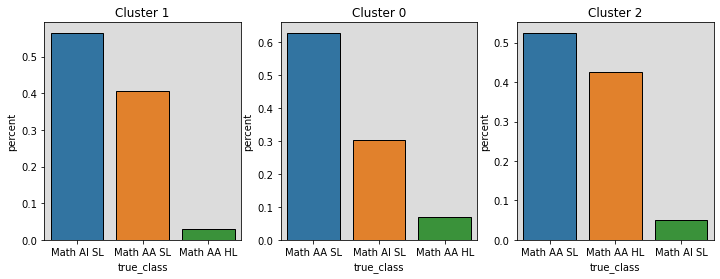

In [116]:
fig, axs = plt.subplots(1, 3, figsize = (12, 4))
for i, cluster in enumerate(all_df_train.kmeans_cluster.unique()):
    (all_df_train[all_df_train.kmeans_cluster == cluster].true_class.value_counts(normalize=True)
         .rename('percent').reset_index()
         .rename(columns = {'index':'true_class'})
         .pipe((sns.barplot,'data'), x = 'true_class', y='percent', ax = axs[i], edgecolor = 'black'))
    axs[i].set_title(f'Cluster {cluster}')
    axs[i].set_facecolor('gainsboro')
    #axs[i].grid(color = 'grey')
plt.show()

<b> Comments <b>

Based on the above, it appears that Cluster 1 is meant for Math AI SL, Cluster 0 is meant for Math AA SL, and Cluster 2 is meant for Math AA HL. These clusters are not clearly defined, however, and this is due to the following reasons:
1. Some students progress significantly over the course of 2 years, and that is due to hard work (or increase in English ability, which made the placement test challenging when they arrive).
2. Some students decide that math is not a priority and prioritize other subjects, this means that while they had potential in the beginning, they did not harness these skills.
3. Some students work really hard to make up for their lack of pre-requisite knowledge.

In [117]:
cluster_assignments = {1: 'Math AI SL', 0: 'Math AA SL', 2: 'Math AA HL'}

In [118]:
all_df_train['kmeans_label'] = all_df_train.kmeans_cluster.apply(lambda x: cluster_assignments[x])

In [119]:
all_df_test['kmeans_cluster'] = kmeans_model.predict(X_test)

In [120]:
all_df_test['kmeans_label'] = all_df_test.kmeans_cluster.apply(lambda x: cluster_assignments[x])


**Error Analysis of KMeans (on validation)**

In [121]:
k_means_error_df_val = create_error_df(all_df_train.loc[X_val.index], X_train, 
                                   all_df_train.loc[X_val.index].true_class, 
                                   all_df_train.loc[X_val.index].kmeans_label, 
                                   model_type = 'clustering')

--------------------F1-score: 0.532, Precision score: 0.576, Recall score 0.546--------------------



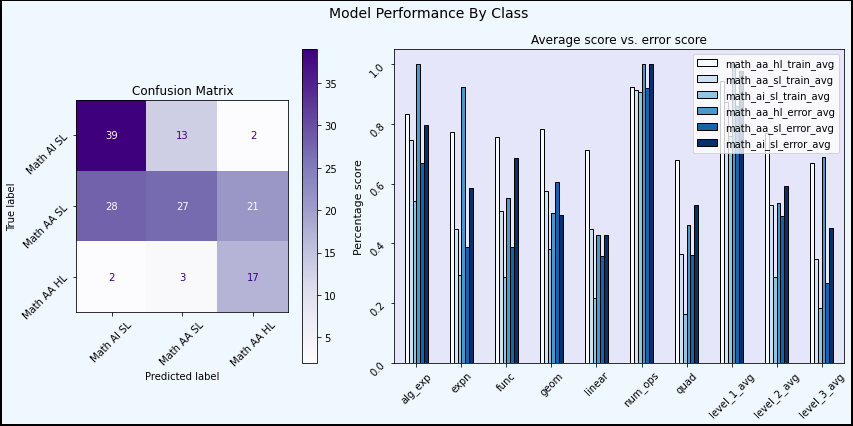

In [122]:
analyze_errors_by_class(all_df_train, k_means_error_df_val, X_train, y_train, all_df_train.kmeans_label)


**Comments**

- Confusion matrix:
1. Math AI SL had both a low precision (0.565) and a slightly higher recall (0.722). This means that the model overclassified things as Math Studies.
2. Math AA SL had a precision of (0.628) and recall of (0.355). This is due to the fact that many true Math AA SL labels were assigned to Math AI SL and Math AA HL. It makes sense that they have low recall because they are the middle level and it is easier for the model to predict the lower or upper class.
3. Lastly, Math AA HL had a high low precision (0.425) and a high recall (0.772). This is because the model is careful to classify students as Math AA HL. Likely this is due to the limited amount of Math AA HL data.
- Bar graph:
1. Math AA HL errors have average scores most similar to Math AA SL.
2. Math AA SL errors have average scores slightly above Math AA SL averages, thus might have been more misclassified as Math AA HL.
3. Math AI SL errors have average scores that are slightly higher than Math AI SL averages, thus explaining the misclassification as Math AA SL.

# Choosing a model <a class = "anchor" id = "choosingmodel"></a>

[Back to top](#backtotop)

## Logistic Regression <a class = "anchor" id = "lr"></a>

[Back to top](#backtotop)

### Selecting hyperparameters

In [123]:
c_values = np.arange(0.3, 1.1, 0.1)

In [124]:
solver = ['lbfgs', 'newton-cg']

In [125]:
lr_hyper_parameter_results = grid_search_lr(X_train, y_train, c_values, solver, plot = False, verbose = False)


Testing 16 combinations 


In [126]:
lr_hyper_parameter_results.sort_values(by = ['val_mean', 'overfit'], 
                                       ascending = [False, True])

,C,solver,train_mean,val_mean,overfit
6,0.6,lbfgs,0.561794,0.549301,0.012493
7,0.6,newton-cg,0.561794,0.549301,0.012493
14,1.0,lbfgs,0.581671,0.548489,0.033182
15,1.0,newton-cg,0.581671,0.548489,0.033182
8,0.7,lbfgs,0.568918,0.543298,0.025620
9,0.7,newton-cg,0.568918,0.543298,0.025620
12,0.9,lbfgs,0.575899,0.539385,0.036515
13,0.9,newton-cg,0.575899,0.539385,0.036515
4,0.5,lbfgs,0.552294,0.536269,0.016025
5,0.5,newton-cg,0.552294,0.536269,0.016025


Best model parameters considering both highest validation mean and overfitting are:
1. C = 0.6
2. solver = lbfgs

In [127]:
lr_model = LogisticRegression(class_weight = 'balanced', C = 0.6, solver = 'lbfgs', random_state = 1234)


Average train f1_weighted 0.5617939867956854
Average validation f1_weighted 0.5493008477367524


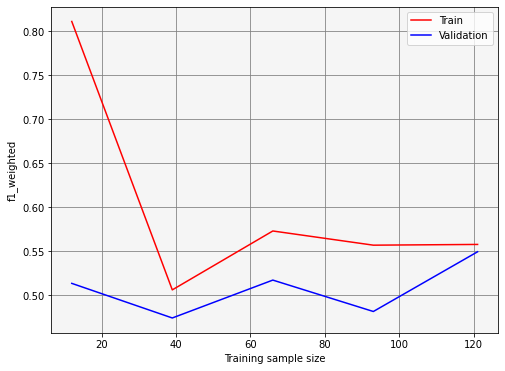

(0.5617939867956854, 0.5493008477367524)

In [128]:
cross_validate_model(lr_model, X_train, y_train, scorer = 'f1_weighted')

### Training on small train set

In [129]:
lr_model.fit(X_train_sm, y_train_sm)

LogisticRegression(C=0.6, class_weight='balanced', random_state=1234)

In [130]:
y_val_pred_lr = lr_model.predict(X_val)

### Model Analysis (validation set)

#### Feature Importance

/Users/hannahlang/Desktop/math_diagnostics_report/project/model_evaluation.py:212: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(feature_names, rotation = 60)
/Users/hannahlang/Desktop/math_diagnostics_report/project/model_evaluation.py:212: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(feature_names, rotation = 60)
/Users/hannahlang/Desktop/math_diagnostics_report/project/model_evaluation.py:212: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(feature_names, rotation = 60)


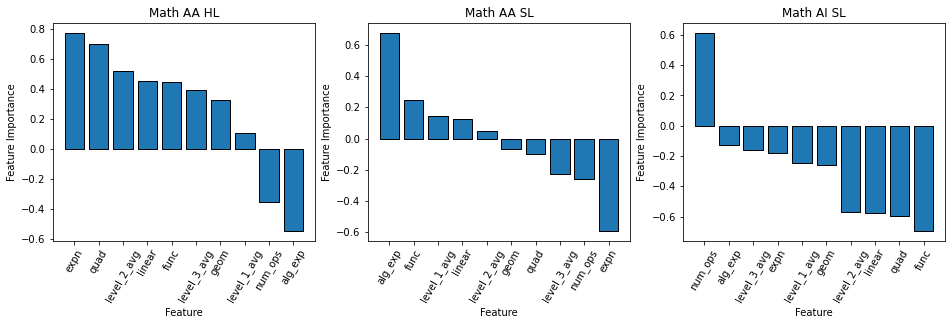

<Figure size 432x288 with 0 Axes>

In [131]:
feature_importance(lr_model, 'LogisticRegression')

##### Comments

- The most important features for predicting Math AA HL students is skills with exponents, quadratics, and level 2 skills average.
- The most important distinguishers for Math AA SL students is their skills with algebraic expressions and their functions average.
- The feature importance for Math AI SL indicates that the only positive feature is ability to work with number operations. If the students are skilled in all of the other areas, it indicates that they are a fit for one of the other classes.

#### Error Analysis

##### General Errors By Class

In [132]:
lr_error_df_val = create_error_df(all_df_train.loc[X_val.index], X_val, y_val, y_val_pred_lr, model =  lr_model)

--------------------F1-score: 0.579, Precision score: 0.660, Recall score 0.581--------------------



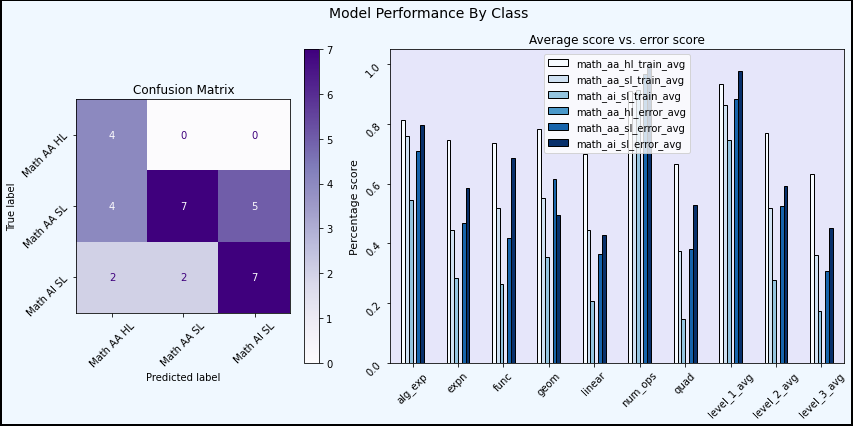

In [133]:
analyze_errors_by_class(all_df, lr_error_df_val, X_train_sm, y_val, y_val_pred_lr)

<b> Comments <b>

- Confusiom Matrix:
1. The model had a high recall for Math AA HL, but a low precision. This means that it over assigned students to Math AA HL.
2. The model had a high precision and low recall for Math AA SL. This means that the model did not assign enough students to Math AA SL.
3. The model had middle-range value for precision and recall. It was not able to identify the class effectively, but it also did not over-assign students to Math AA SL. It confused some Math AI SL students as Math AA SL students.

- Bar Graph: 
1. We can see there were no Math AA HL errors, as in, no students that were supposed to be assigned to Math AA HL were assigned to a different class.
2. Math AA SL error averages were slightly below average Math AA SL student averages, this is perhaps why the model assigned some to Math AI SL.
3. Math AI SL error averages were far above the average Math AI SL scores. This is perhaps why some Math AI SL students were assigne to Math AA SL.

##### Individual Errors

In [134]:
interact(analyze_errors_idx, all_df = fixed(all_df_val), error_df = fixed(lr_error_df_val), idx = lr_error_df_val.index)

interactive(children=(Dropdown(description='idx', options=('Student 143', 'Student 59', 'Student 75', 'Student…

<function model_evaluation.analyze_errors_idx(all_df, error_df, idx)>

<b>Sample output of widget</b>

<img src="individual_errors_widget.png" alt="drawing" width="550"/>

<b> Comments <b>

1. The above tool visualizes all of the errors of the model on the validation set.
2. The model predicts more closely to the cluster label. 
3. As can be seen above, the model predicts the class generally based on how similar the student results are to the average class results.

##### Confidence Intervals

In [137]:
pci = predict_confidence_intervals(lr_model)

In [138]:
pci.fit(X_train_sm, y_train_sm)

predict_confidence_intervals(estimator=LogisticRegression(C=0.6,
                                                          class_weight='balanced',
                                                          random_state=1234))

48.39% of the predictions were predicted with probability above 0.5.


25.81% of the lower boundaries of the confidence intervals had probabilities above 0.5.




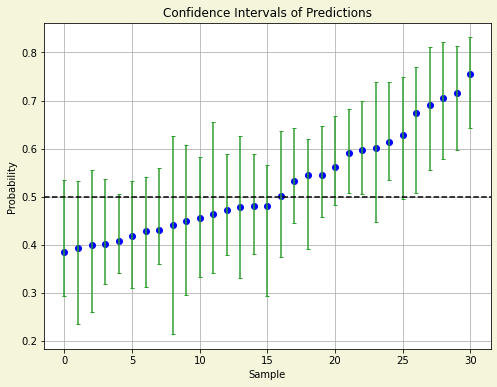

In [139]:
confidence_int_df_val_lr = pci.predict(X_val,  c_i = 95, plot = True)


In [140]:
interact(confidence_interval_info_by_idx,
         idx = y_val.index,
         confidence_int_df = fixed(confidence_int_df_val_lr), 
         true_label = fixed(y_val), 
         c_i = fixed(95))

interactive(children=(Dropdown(description='idx', options=('Student 146', 'Student 59', 'Student 171', 'Studen…

<function model_evaluation.confidence_interval_info_by_idx(idx, confidence_int_df, true_label, c_i)>

<b> Sample of confidence interval widget: </b>

<img src="confidence_interval_widget.png" alt="drawing" width="350"/>

In [141]:
print('{:.2%}% of the predicted labels and lower confidence labels matched the true label'.format(((confidence_int_df_val_lr.pred_label == y_val) 
 | (confidence_int_df_val_lr.lower_conf_label == y_val)).mean()))

74.19%% of the predicted labels and lower confidence labels matched the true label


<b>Comments <b>

- We can see that the model is not so confident in its predictions. Only half of the probabilities are above 0.5.
- As we can see from the interactive tool above, lower confidence labels are usually not the same as the predicted label.
- There are many cases where both the predicted and lower confidence interval label do not match the true label. This makes the model not very reliable.

## Random Forest <a class = "anchor" id = "rf"></a>

[Back to top](#backtotop)

### Training the model

In [142]:
# n_estimators, min_samples_split, min_samples_leaf, max_features
min_samples_split = [2, 5, 10, 20]
min_samples_leaf = [1, 5, 10, 20]
criterion= ['gini', 'entropy']
max_features = ['sqrt', 'log2', None]

In [143]:
rf_grid_search = grid_search_rf(X_train, y_train, min_samples_split, min_samples_leaf, criterion, max_features, plot = False, verbose = False)

Testing 96 combinations 


In [144]:
rf_grid_search.sort_values(by = ['val_mean', 'overfit'],
                           ascending = [False, True]).head(20)

,min_split,min_leaf,split_criterion,max_features,train_mean,val_mean,overfit
75,20,1,entropy,sqrt,0.744999,0.648745,0.096254
76,20,1,entropy,log2,0.744999,0.648745,0.096254
77,20,1,entropy,None,0.774730,0.648169,0.126561
74,20,1,gini,None,0.749848,0.643267,0.106582
83,20,5,entropy,None,0.754309,0.635285,0.119024
12,2,10,gini,sqrt,0.693383,0.630388,0.062995
13,2,10,gini,log2,0.693383,0.630388,0.062995
36,5,10,gini,sqrt,0.693383,0.630388,0.062995
37,5,10,gini,log2,0.693383,0.630388,0.062995
60,10,10,gini,sqrt,0.693383,0.630388,0.062995


We will choose parameters that have the highest performance with the least amount of overfitting.

In [145]:
rf_model = RandomForestClassifier(n_estimators = 100,
                                  min_samples_split = 2,
                                  min_samples_leaf = 10,
                                  criterion = 'gini',
                                  max_features = 'sqrt',
                                  class_weight = 'balanced',
                                  random_state = 1234)

Average train f1_weighted 0.6933829956365696
Average validation f1_weighted 0.6303879928497039


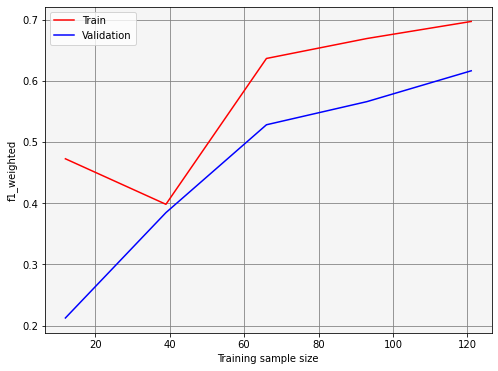

(0.6933829956365696, 0.6303879928497039)

In [146]:
cross_validate_model(rf_model, X_train, y_train, scorer = 'f1_weighted')

In [147]:
rf_model.fit(X_train_sm, y_train_sm)

RandomForestClassifier(class_weight='balanced', max_features='sqrt',
                       min_samples_leaf=10, random_state=1234)

In [148]:
y_val_pred_rf = rf_model.predict(X_val)

### Model Analysis (validation set)

#### Feature Importance

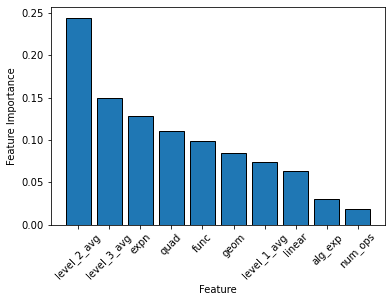

<Figure size 432x288 with 0 Axes>

In [149]:
feature_importance(rf_model, 'RandomForest')

##### Comments

- The most important features were the the level 2 average, level 3 average, and exponents.
- The most important skills were exponents, quadratics, and functions. These skills are not surprising as they tend to be heavily used in the first units of the course. 

#### Error Analysis

##### General Errors By Class

In [150]:
#all_df, X, y_true, y_pred, model_type = 'classification', model = None
rf_errors_df_val = create_error_df(all_df_train.loc[X_val.index], 
                               X_val, y_val, 
                               rf_model.predict(X_val), 
                               model = rf_model)

--------------------F1-score: 0.617, Precision score: 0.638, Recall score 0.613--------------------



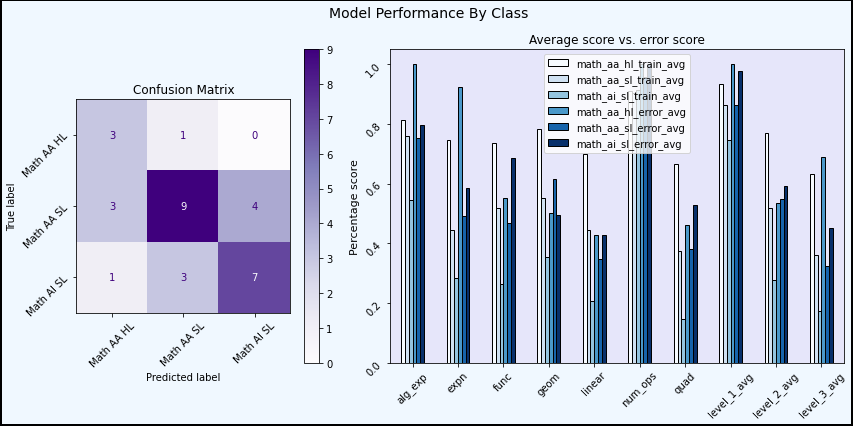

In [151]:
analyze_errors_by_class(all_df, rf_errors_df_val, X_train_sm, y_val, y_val_pred_rf)

<b> Comments <b>

- Confusion Matrix:
1. Math AA HL has a high recall (0.75), but low precision (0.429). The model over-classifies Math AA HL.
2. Math AA SL has a relatively high recall (0.692) and lower precision (0.563)
3. Math AI SL has a recall of (0.636) and precision of (0.636)
4. Generally the model over-predicts rather than under-predicts, which is actually optimal, as we would rather give students the opportunity to try out difficult classes if they are capable.

- Bar Graph:
1. The Math AA HL error has a lower average than Math AA HL averages. Hence, why it must have been classified as Math AA SL.
2. The Math AA SL error averages were a mix of lower and higher than Math AA SL averages.
3. The Math AI SL error averages were generally higher than the Math AI SL averages, hence the label as Math AA SL.

##### Individual Errors

In [152]:
interact(analyze_errors_idx, all_df = fixed(all_df_train.loc[X_val.index]), error_df = fixed(rf_errors_df_val), ib_results = fixed(ib_results), idx = rf_errors_df_val.index)


interactive(children=(Dropdown(description='idx', options=('Student 143', 'Student 118', 'Student 59', 'Studen…

<function model_evaluation.analyze_errors_idx(all_df, error_df, idx)>

<b>Comments<b>
- Most of the predicted labels and cluster labels match.

##### Confidence Intervals

In [153]:
pci_rf = predict_confidence_intervals(rf_model)

In [154]:
pci_rf.fit(X_train_sm, y_train_sm)

predict_confidence_intervals(estimator=RandomForestClassifier(class_weight='balanced',
                                                              max_features='sqrt',
                                                              min_samples_leaf=10,
                                                              random_state=1234))

74.19% of the predictions were predicted with probability above 0.5.


16.13% of the lower boundaries of the confidence intervals had probabilities above 0.5.




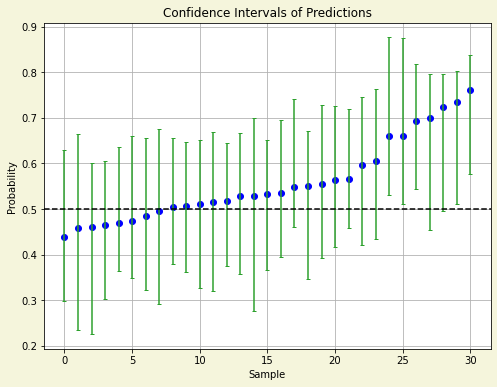

In [155]:
confidence_int_df_val_rf = pci_rf.predict(X_val,  c_i = 95, plot = True)

In [156]:
interact(confidence_interval_info_by_idx,
         idx = y_val.index,
         confidence_int_df = fixed(confidence_int_df_val_rf), 
         true_label = fixed(y_val), 
         c_i = fixed(95))

interactive(children=(Dropdown(description='idx', options=('Student 146', 'Student 59', 'Student 171', 'Studen…

<function model_evaluation.confidence_interval_info_by_idx(idx, confidence_int_df, true_label, c_i)>

In [157]:
print('{:.2%}% of the predicted labels and lower confidence labels matched the true label'.format(((confidence_int_df_val_rf.pred_label == y_val) 
 | (confidence_int_df_val_rf.lower_conf_label == y_val)).mean()))

83.87%% of the predicted labels and lower confidence labels matched the true label


<b>Comments<b>
- More of the predicted probabilities were above 0.5, but the confidence intervals were wider than the logistic regression model. 
- Most of the lower confidence interval labels were different from the predicted probability label.
- The same number of predicted labels, low confidence label match the true label than in the random forest model. 
- Since the recall is higher, and we generally prefer recall (we want to detect more of who belongs to each class), we will go with the random forest model. It also has a better balance between precision and recall.

# Model Evaluation <a class = "anchor" id = "modelevaluation"></a>

[Back to top](#backtotop)

## Sanity Check Results Test Set

In [158]:
y_pred_test_sanity = pd.Series(['Math AA SL']*len(y_test), index = all_df_test.index)

In [159]:
sanity_error_df = create_error_df(all_df_test, X_train, 
                                   all_df_test.true_class, 
                                   y_pred_test_sanity, 
                                   model_type = 'clustering')

--------------------F1-score: 0.333, Precision score: 0.250, Recall score 0.500--------------------



/Users/hannahlang/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


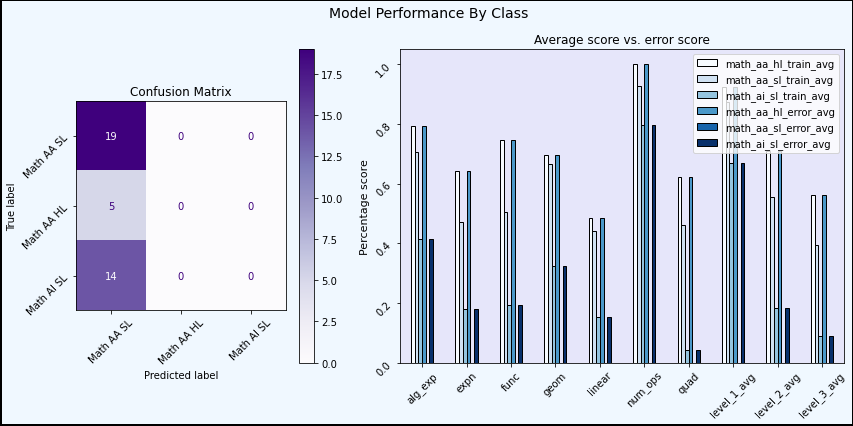

In [160]:
analyze_errors_by_class(all_df_test, sanity_error_df, X_test, y_test, y_pred_test_sanity)

**Comments**

- When we label every sample as "Math AA SL", the precision score is low and the recall score is higher, which is expected.
- Our minimum baseline performance on the test set is an F1 score of 0.333

## Training Selected Model (whole train set)

The model to be selected is the random forest model with the following hyperparameters:
1. n_estimators = 100
2. min_samples_split = 2
3. min_samples_leaf = 10
4. criterion = 'gini'
5. max_features = 'sqrt'
6. class_weight = 'balanced'
7. random_state = 1234

In [161]:
rf_model = RandomForestClassifier(n_estimators = 100,
                                  min_samples_split = 2,
                                  min_samples_leaf = 10,
                                  criterion = 'gini',
                                  max_features = 'sqrt',
                                  class_weight = 'balanced',
                                  random_state = 1234)

In [162]:
pickle.dump(rf_model, open('../ready_model/base_model_untrained_10_6.pkl', 'wb'))

In [163]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_features='sqrt',
                       min_samples_leaf=10, random_state=1234)

In [164]:
y_test_pred_rf = rf_model.predict(X_test)

## Feature Importance

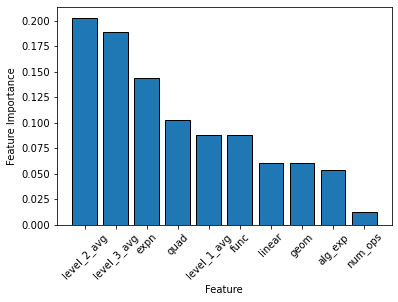

<Figure size 432x288 with 0 Axes>

In [165]:
feature_importance(rf_model, 'RandomForest')

**Comments**

- The most important features are the level 2 average, level 3 average, and score on exponents.
- The most important skills are exponents, quadratics, and functions. This is what we would expect and shows slightly different results than the model trained on the small training set.

## General Errors

In [166]:
rf_errors_df_test = create_error_df(all_df_test, 
                               X_test, y_test, 
                               rf_model.predict(X_test), 
                               model = rf_model)

--------------------F1-score: 0.685, Precision score: 0.694, Recall score 0.684--------------------



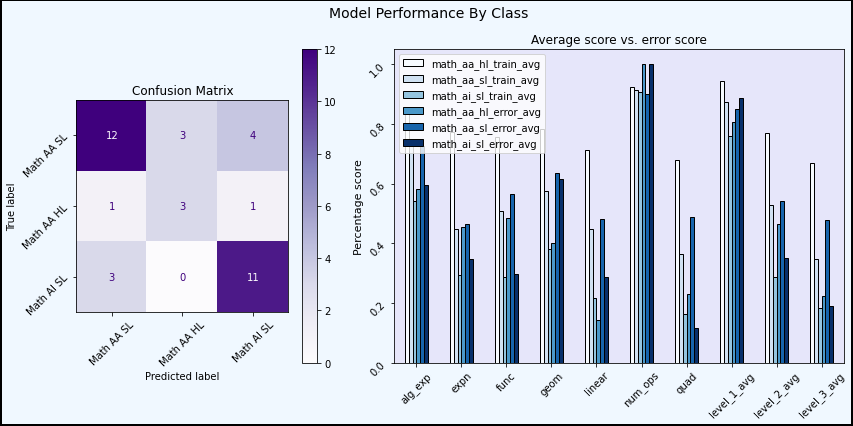

In [167]:
analyze_errors_by_class(all_df, rf_errors_df_test, X_train, y_test, y_test_pred_rf)

**Comments**

- Confusion Matrix
1. The model performed much better on the whole train set and test set.
2. Precision and recall were both high, and the F1 score was much better than the sanity check of 0.333.
3. The model did the best in classifying students for Math AI SL with a precision of (0.688) and a recall of (0.786).
4. The model had a precision of (0.75) for Math AA SL and a recall of (0.632).
5. The model had a precision of (0.5) and a recall of (0.6) for Math  AA HL. 
6. It would be ideal if the recall score were higher for Math AA HL than the other subjects, but this is likely a problem due to the limited amount of data.

## Individual Errors

In [168]:
interact(analyze_errors_idx, all_df = fixed(all_df_test), error_df = fixed(rf_errors_df_test), ib_results = fixed(ib_results), idx = rf_errors_df_test.index)

interactive(children=(Dropdown(description='idx', options=('Student 158', 'Student 40', 'Student 61', 'Student…

<function model_evaluation.analyze_errors_idx(all_df, error_df, idx)>

**Comments**

- Most of the error predicted labels of the model were the same as the cluster labels.

## Confidence Intervals

In [169]:
pci_rf = predict_confidence_intervals(rf_model)

In [170]:
pci_rf.fit(X_train, y_train)

predict_confidence_intervals(estimator=RandomForestClassifier(class_weight='balanced',
                                                              max_features='sqrt',
                                                              min_samples_leaf=10,
                                                              random_state=1234))

78.95% of the predictions were predicted with probability above 0.5.


31.58% of the lower boundaries of the confidence intervals had probabilities above 0.5.




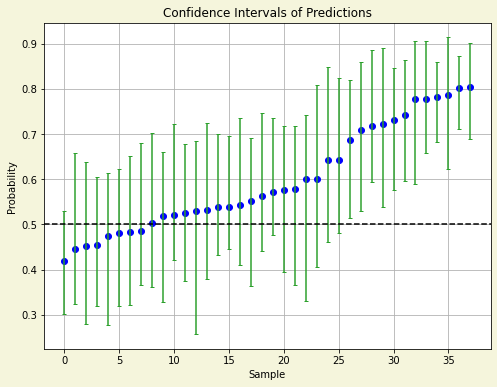

In [171]:
confidence_int_df_test_rf = pci_rf.predict(X_test,  c_i = 95, plot = True)

In [172]:
interact(confidence_interval_info_by_idx,
         idx = y_test.index,
         confidence_int_df = fixed(confidence_int_df_test_rf), 
         true_label = fixed(y_test), 
         c_i = fixed(95))

interactive(children=(Dropdown(description='idx', options=('Student 110', 'Student 108', 'Student 150', 'Stude…

<function model_evaluation.confidence_interval_info_by_idx(idx, confidence_int_df, true_label, c_i)>

In [173]:
print('{:.2%}% of the predicted labels and lower confidence labels matched the true label'.format(((confidence_int_df_test_rf.pred_label == y_test) 
 | (confidence_int_df_test_rf.lower_conf_label == y_test)).mean()))

89.47%% of the predicted labels and lower confidence labels matched the true label


**Comments**

- In 90% of cases, the predicted label or the lower confidence label matches the true label. This means that students can be allowed to stay in a subject if it's not their predicted class, if the lower confidence interval predicts it as its class.

# Model vs. Teacher Performance <a class = "anchor" id = "modelvsteacher"></a>

[Back to top](#backtotop)

## Teacher Performance

In [174]:
math_all = pd.concat([math_2019[['Recommended Course']], 
                      math_2020[['Recommended Course']],
                      math_2021[['Recommended Course']]])

In [175]:
math_all = math_all.merge(all_df['true_class'], left_index = True, right_index = True)

In [176]:
math_all['Recommended Course'].value_counts()

Math Studies              58
Math SL                   44
Math HL                   31
Applied SL                21
Analysis SL               15
Analysis HL               12
Analysis HL?               2
Analysis SL?               1
Math Studies               1
Analysis SL or HL          1
Applied or Analysis SL     1
Math S                     1
Math studies               1
Math SL                    1
Name: Recommended Course, dtype: int64

In [177]:
def updated_recommended(subject):
    if (subject == 'Math Studies'
        or subject == 'Applied SL' 
        or subject == 'Math Studies ' 
        or subject == 'Math studies'):
        return 'Math AI SL'
    elif (subject == 'Math SL'
          or subject == 'Analysis SL' 
          or subject == 'Math S' 
          or subject == 'Math SL ' 
          or subject == 'Analysis SL?' 
          or subject == 'Applied or Analysis SL'):
        return 'Math AA SL'
    elif (subject == 'Math HL'
          or subject == 'Analysis HL' 
          or subject == 'Analysis HL?' 
          or subject == 'Analysis SL or HL'):
        return 'Math AA HL'
    else:
        return subject

In [178]:
math_all['Recommended Course'] = math_all['Recommended Course'].apply(updated_recommended)

In [179]:
math_all['Recommended Course'].value_counts()

Math AI SL    81
Math AA SL    63
Math AA HL    46
Name: Recommended Course, dtype: int64

In [180]:
math_all_test = math_all.loc[X_test.index]

In [181]:
teacher_acc = (math_all_test['true_class'] == math_all_test['Recommended Course']).mean()

In [182]:
teacher_acc

0.6578947368421053

In [183]:
teacher_f1 = f1_score(math_all_test['true_class'], math_all_test['Recommended Course'], average = 'weighted')

In [184]:
teacher_f1

0.6476100300378739

## Model Performance 

In [185]:
model_acc = (y_test == y_test_pred_rf).mean()

In [186]:
model_acc

0.6842105263157895

In [187]:
model_f1 = f1_score(y_test, y_test_pred_rf, average = 'weighted')

In [188]:
model_f1

0.6848029163818637

## Comparison

In [189]:
print('The model outperforms teachers by {:.2%} in f1-score.'.format((model_f1-teacher_f1)/teacher_f1))

The model outperforms teachers by 5.74% in f1-score.


In [190]:
print('The model outperforms teachers by {:.2%} in accuracy.'.format((model_acc-teacher_acc)/teacher_acc))

The model outperforms teachers by 4.00% in accuracy.
